In [1]:
#Standard

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE

#Keras
import sysidentpy
from torch import nn

#others
from tqdm.notebook import tqdm
import itertools

In [2]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.model_structure_selection import AOLS

from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.metrics import r2_score,max_error, mean_absolute_error, mean_squared_error

In [3]:
def inputs_selection(key, target = 'Pressure'):
     
    if target == 'Pressure':
    
        inputs_dict = {
            1:'AVG_DOWNHOLE_PRESSURE',
            2:'AVG_DOWNHOLE_TEMPERATURE',
            3:'BORE_OIL_VOL', #paper used wellhead pressure
            4:'BORE_GAS_VOL',
            5:'BORE_WAT_VOL',
            6:'AVG_CHOKE_SIZE_P',
            7:'ON_STREAM_HRS'
        }
        
    else:
        
        inputs_dict = {
            1:'CUMALATIVE_TIME',
            2:'AVG_DOWNHOLE_TEMPERATURE',
            3:'AVG_DOWNHOLE_PRESSURE', #paper used wellhead pressure
            4:'AVG_CHOKE_SIZE_P',
            5:'AVG_RS',
            6:'AVG_DP_TUBING',
            7:'DP_CHOKE_SIZE',
            8:'BORE_OIL_VOL',
            9:'BORE_GAS_VOL',
            10:'BORE_WAT_VOL'}

    inputs = []
    
    for i in key:
        inputs.append(inputs_dict[i])    
    return inputs

In [4]:
def create_train_test(data, columns, test_size = 0.2):

    train_index = int(data.shape[0]*(1-test_size))
    train_data = df.iloc[:train_index,:]
    test_data = df.iloc[train_index:,:]

    print('TARGET SELECTED = ', inputs_selection([1]))
    
    print('FEATURES SELECTED = ', inputs_selection(columns))
    
    train_X, test_X = train_data.loc[:,inputs_selection(columns)], test_data.loc[:,inputs_selection(columns)]
    train_y, test_y = train_data.loc[:,inputs_selection([1])], test_data.loc[:,inputs_selection([1])]
    
    return np.array(train_X), np.array(test_X), np.array(train_y), np.array(test_y)

In [5]:
def model_train_results(model, train_X, train_y, test_X, test_y):
    
    model.fit(X=train_X, y=train_y)
    
    yhat = model.predict(X=test_X, y=test_y)

    rrse = root_relative_squared_error(test_y, yhat)
    print('RRSE: ',rrse)
    print('R2: ',round(r2_score(test_y, yhat),5))
    
    plot_results(y=test_y, yhat = yhat)
    
    ee = compute_residues_autocorrelation(test_y, yhat)
    plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
    x1e = compute_cross_correlation(test_y, yhat, test_X)
    plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")
    
    return model
    
'''
results_ = pd.DataFrame(
results(
    model.final_model, model.theta, model.err,
    model.n_terms, err_precision=8, dtype='sci'
    ),
columns=['Regressors', 'Parameters', 'ERR'])
print(results_)
'''

"\nresults_ = pd.DataFrame(\nresults(\n    model.final_model, model.theta, model.err,\n    model.n_terms, err_precision=8, dtype='sci'\n    ),\ncolumns=['Regressors', 'Parameters', 'ERR'])\nprint(results_)\n"

In [6]:
#df = pd.read_csv('Volve_NO15-9-F-14H.csv', sep =';', decimal = ',' )

df = pd.read_csv('Volve_production_data.csv', sep =';', decimal = ',' )

#df['AVG_RS'] = pd.to_numeric(df['RS'],errors = 'coerce')
columns_df = list(df)
display(columns_df)

filtro = df.AVG_DOWNHOLE_PRESSURE == 0
df = df.loc[df.AVG_DOWNHOLE_PRESSURE > 0]

CUMALATIVE_TIME = np.arange(1,df.shape[0]+1)
df.insert(1,'CUMALATIVE_TIME', CUMALATIVE_TIME)

df.AVG_CHOKE_SIZE_P = df.AVG_CHOKE_SIZE_P.fillna(0)
display(df.isnull().sum())

filtro = df.WELL_BORE_CODE == 'NO 15/9-F-1 C'
df = df.loc[filtro]
df

['DATEPRD',
 'month',
 'year',
 'month-year',
 'WELL_BORE_CODE',
 'NPD_WELL_BORE_CODE',
 'NPD_WELL_BORE_NAME',
 'NPD_FIELD_CODE',
 'NPD_FIELD_NAME',
 'NPD_FACILITY_CODE',
 'NPD_FACILITY_NAME',
 'ON_STREAM_HRS',
 'AVG_DOWNHOLE_PRESSURE',
 'AVG_DOWNHOLE_TEMPERATURE',
 'AVG_DP_TUBING',
 'AVG_ANNULUS_PRESS',
 'AVG_CHOKE_SIZE_P',
 'AVG_CHOKE_UOM',
 'AVG_WHP_P',
 'AVG_WHT_P',
 'DP_CHOKE_SIZE',
 'BORE_OIL_VOL',
 'BORE_GAS_VOL',
 'BORE_WAT_VOL',
 'BORE_WI_VOL',
 'FLOW_KIND',
 'WELL_TYPE',
 'AVG_RS']

DATEPRD                        0
CUMALATIVE_TIME                0
month                          0
year                           0
month-year                     0
WELL_BORE_CODE                 0
NPD_WELL_BORE_CODE             0
NPD_WELL_BORE_NAME             0
NPD_FIELD_CODE                 0
NPD_FIELD_NAME                 0
NPD_FACILITY_CODE              0
NPD_FACILITY_NAME              0
ON_STREAM_HRS                  0
AVG_DOWNHOLE_PRESSURE          0
AVG_DOWNHOLE_TEMPERATURE       0
AVG_DP_TUBING                  0
AVG_ANNULUS_PRESS           1244
AVG_CHOKE_SIZE_P               0
AVG_CHOKE_UOM                  0
AVG_WHP_P                      0
AVG_WHT_P                      0
DP_CHOKE_SIZE                  0
BORE_OIL_VOL                   0
BORE_GAS_VOL                   0
BORE_WAT_VOL                   0
BORE_WI_VOL                 6668
FLOW_KIND                      0
WELL_TYPE                      0
AVG_RS                         0
dtype: int64

,DATEPRD,CUMALATIVE_TIME,month,year,month-year,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,...,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE,AVG_RS
4,11-abr-14,1,4,2014,4-2014,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,33.098,10.480,33.072,0,0,0,NaN,production,OP,"143,41"
5,12-abr-14,2,4,2014,4-2014,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,22.053,8.704,22.053,0,0,0,NaN,production,OP,"143,41"
6,13-abr-14,3,4,2014,4-2014,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,27.503,9.423,16.163,0,0,0,NaN,production,OP,"143,41"
7,14-abr-14,4,4,2014,4-2014,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,20.996,8.131,20.737,0,0,0,NaN,production,OP,"143,41"
8,15-abr-14,5,4,2014,4-2014,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,13.918,8.498,12.182,0,0,0,NaN,production,OP,"143,41"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,16-abr-16,737,4,2016,4-2016,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,8.675,10.079,0.068,0,0,0,NaN,production,OP,"164,03"
741,17-abr-16,738,4,2016,4-2016,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,6.498,9.802,2.645,0,0,0,NaN,production,OP,"164,03"
742,18-abr-16,739,4,2016,4-2016,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,13.714,11.742,4.120,0,0,0,NaN,production,OP,"164,03"
743,19-abr-16,740,4,2016,4-2016,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,...,8.576,10.119,1.866,0,0,0,NaN,production,OP,"164,03"


In [7]:
filtro = df.WELL_BORE_CODE == 'NO 15/9-F-1 C'
df = df.loc[filtro]

display(df.describe())
display(df.info())

data = pd.DataFrame()
columns = ['AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P','ON_STREAM_HRS']
for element in columns:
    data[element] = df[element].astype(float)
    
display(data)

df = data

,CUMALATIVE_TIME,month,year,NPD_WELL_BORE_CODE,NPD_FIELD_CODE,NPD_FACILITY_CODE,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE
count,741.000000,741.000000,741.000000,741.0,741.0,741.0,741.000000,741.000000,741.000000,741.000000,12.0,741.000000,741.000000,741.000000,741.000000
mean,371.000000,6.485830,2014.792173,7405.0,3420717.0,369304.0,13.473117,247.331802,105.208502,193.059900,0.0,29.794760,54.271901,40.681707,32.867982
std,214.052564,3.440832,0.681805,0.0,0.0,0.0,11.648709,27.989949,3.444302,34.737646,0.0,25.456168,32.778244,25.991235,30.410005
min,1.000000,1.000000,2014.000000,7405.0,3420717.0,369304.0,0.000000,207.219000,95.876000,152.926000,0.0,0.000000,0.000000,2.078000,0.000000
25%,186.000000,4.000000,2014.000000,7405.0,3420717.0,369304.0,0.000000,220.902000,101.291000,169.593000,0.0,0.026000,32.265000,11.299000,9.028000
50%,371.000000,6.000000,2015.000000,7405.0,3420717.0,369304.0,24.000000,240.736000,107.821000,182.852000,0.0,46.787730,43.292000,53.394000,17.937000
75%,556.000000,9.000000,2015.000000,7405.0,3420717.0,369304.0,24.000000,271.298000,108.140000,205.706000,0.0,51.286290,75.649000,62.426000,52.202000
max,741.000000,12.000000,2016.000000,7405.0,3420717.0,369304.0,25.000000,313.871000,108.502000,305.976000,0.0,93.635430,133.593000,83.420000,115.639000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 741 entries, 4 to 744
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATEPRD                   741 non-null    object 
 1   CUMALATIVE_TIME           741 non-null    int32  
 2   month                     741 non-null    int64  
 3   year                      741 non-null    int64  
 4   month-year                741 non-null    object 
 5   WELL_BORE_CODE            741 non-null    object 
 6   NPD_WELL_BORE_CODE        741 non-null    int64  
 7   NPD_WELL_BORE_NAME        741 non-null    object 
 8   NPD_FIELD_CODE            741 non-null    int64  
 9   NPD_FIELD_NAME            741 non-null    object 
 10  NPD_FACILITY_CODE         741 non-null    int64  
 11  NPD_FACILITY_NAME         741 non-null    object 
 12  ON_STREAM_HRS             741 non-null    float64
 13  AVG_DOWNHOLE_PRESSURE     741 non-null    float64
 14  AVG_DOWNHO

None

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,AVG_CHOKE_SIZE_P,ON_STREAM_HRS
4,310.376,96.876,0.0,0.0,0.0,1.21599,0.0
5,303.501,96.923,0.0,0.0,0.0,3.08702,0.0
6,303.535,96.959,0.0,0.0,0.0,1.96237,0.0
7,303.782,96.969,0.0,0.0,0.0,0.00000,0.0
8,303.858,97.021,0.0,0.0,0.0,31.14186,0.0
...,...,...,...,...,...,...,...
740,266.148,101.170,0.0,0.0,0.0,0.00000,0.0
741,270.268,101.198,0.0,0.0,0.0,0.00000,0.0
742,276.869,101.231,0.0,0.0,0.0,0.00000,0.0
743,282.105,101.178,0.0,0.0,0.0,0.26519,0.0


In [8]:
df

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,AVG_CHOKE_SIZE_P,ON_STREAM_HRS
4,310.376,96.876,0.0,0.0,0.0,1.21599,0.0
5,303.501,96.923,0.0,0.0,0.0,3.08702,0.0
6,303.535,96.959,0.0,0.0,0.0,1.96237,0.0
7,303.782,96.969,0.0,0.0,0.0,0.00000,0.0
8,303.858,97.021,0.0,0.0,0.0,31.14186,0.0
...,...,...,...,...,...,...,...
740,266.148,101.170,0.0,0.0,0.0,0.00000,0.0
741,270.268,101.198,0.0,0.0,0.0,0.00000,0.0
742,276.869,101.231,0.0,0.0,0.0,0.00000,0.0
743,282.105,101.178,0.0,0.0,0.0,0.26519,0.0


#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5
RMSE:  0.6172789529910528
R2:  0.89415
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = s

RMSE:  0.6025669947830722
R2:  0.89639
#####################################################################
 Order Selected:     15
RMSE:  0.574877408659196
R2:  0.90827
#####################################################################
 Order Selected:     20
RMSE:  0.5747974924006183
R2:  0.90744


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,2.521880,-0.103273,False
3,4,0.402788,0.884175,False
4,5,0.381033,0.894147,False
5,10,0.363087,0.896387,False
6,15,0.330484,0.908268,True
7,20,0.330392,0.907440,False


0.908267516871839 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E220447580> 15
   Regressors   Parameters             ERR
0      y(k-1)   1.0346E+00  9.99464631E-01
1      y(k-2)  -2.1717E-01  1.00881450E-04
2    x1(k-16)   3.5017E-01  1.87840598E-05
3     x1(k-1)  -1.2115E+00  3.40686126E-05
4           1   1.6560E+02  2.17276946E-05
5      y(k-4)   8.1299E-02  3.94199214E-06
6     x1(k-6)  -2.1554E-01  2.76160687E-06
7     x1(k-7)   9.6619E-01  1.01235896E-06
8     x1(k-5)  -2.4820E-01  2.88834432E-06
9     y(k-15)  -5.2872E-01  2.55499427E-06
10   x1(k-11)  -1.3577E-01  9.57317114E-07
11    y(k-14)   9.8632E-02  1.31433246E-06
12   x1(k-20)  -3.5592E-01  1.81761660E-06
13     y(k-9)   3.5132E-02  3.75325731E-07
14     y(k-6)  -3.7712E-02  2.31753895E-07


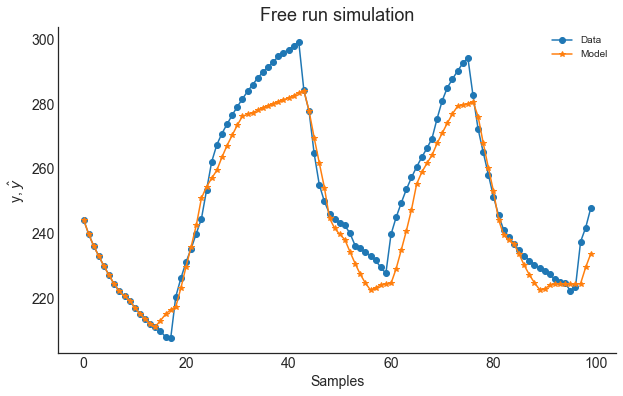

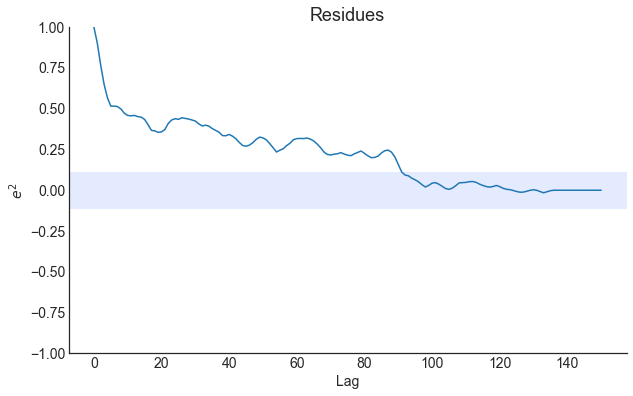

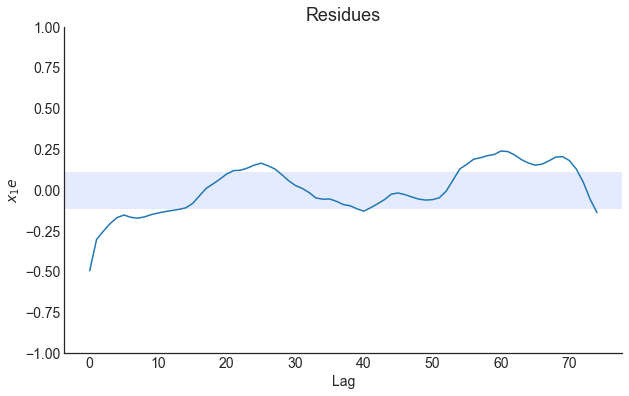

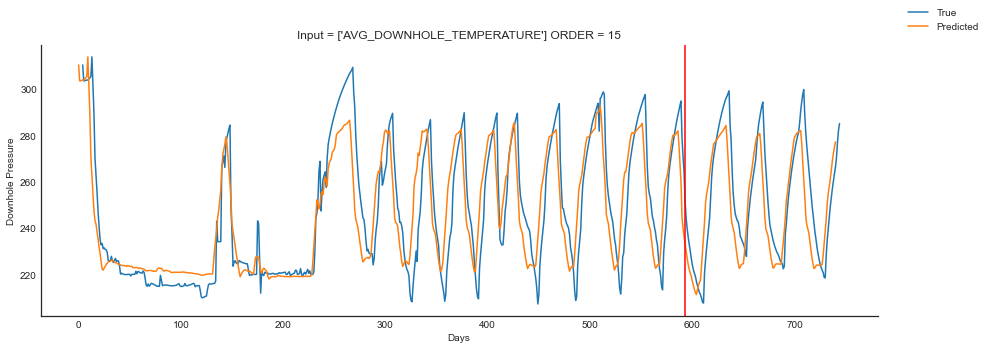

#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  1.2526679096835887
R2:  0.53042
#####################################################################
 Order Selected:     5
RMSE:  1.2307447143736627
R2:  0.56686
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = s

RMSE:  1.1490540141464987
R2:  0.59802
#####################################################################
 Order Selected:     15
RMSE:  1.0316868128012213
R2:  0.63912
#####################################################################
 Order Selected:     20
RMSE:  1.0128174923988016
R2:  0.63616


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,2.521880,-0.103273,False
3,4,1.569177,0.530419,False
4,5,1.514733,0.566856,False
5,10,1.320325,0.598023,False
6,15,1.064378,0.639121,True
7,20,1.025799,0.636162,False


0.639121064831428 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E2202F49A0> 15
   Regressors   Parameters             ERR
0      y(k-1)   1.2178E+00  9.99464631E-01
1      y(k-2)  -2.2790E-01  1.00881450E-04
2    x1(k-15)   1.2206E-03  1.56993888E-05
3     x1(k-1)  -1.0814E-02  1.07843824E-05
4           1   1.7770E+01  2.68964609E-05
5     x1(k-2)   6.3764E-03  3.78682949E-06
6      y(k-6)  -4.1403E-02  5.13133639E-06
7     y(k-20)  -1.5482E-03  1.37005983E-06
8     y(k-14)   3.4402E-03  8.81533402E-07
9    x1(k-19)  -1.3564E-03  4.54906657E-07
10    y(k-15)  -2.3382E-03  4.55157895E-07
11    x1(k-5)   1.1860E-01  3.67137172E-07
12    x1(k-8)  -1.3163E-01  5.29864119E-06
13    y(k-10)   3.9734E-02  5.50595059E-07
14   x1(k-20)  -4.2754E-02  4.41611511E-07


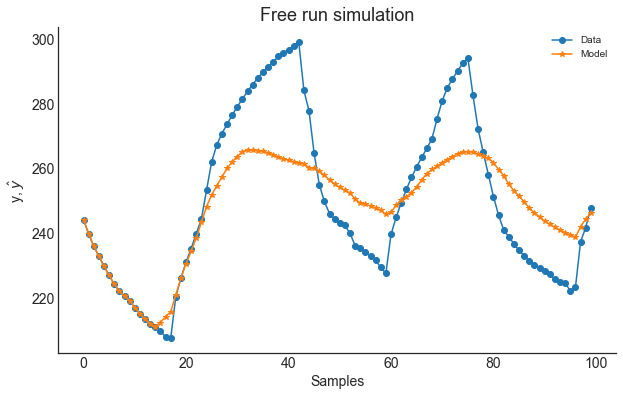

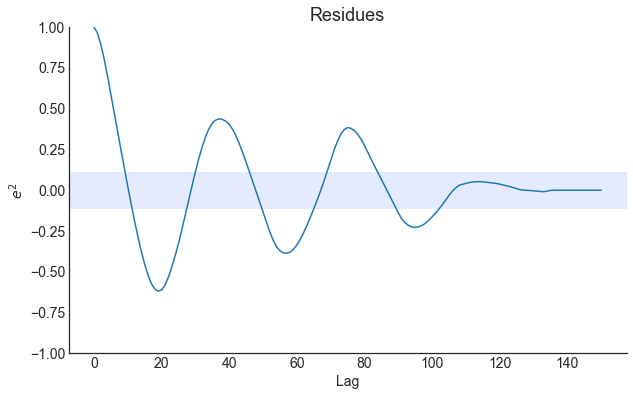

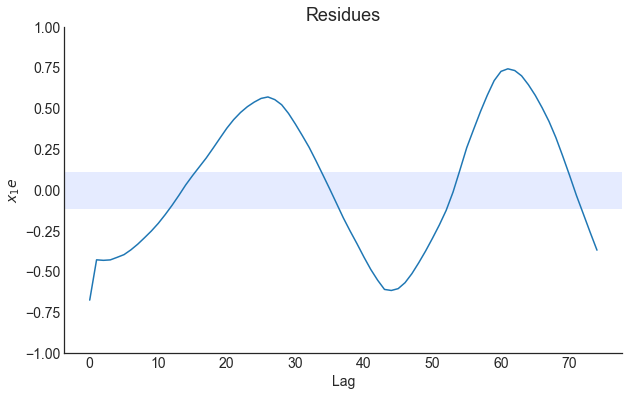

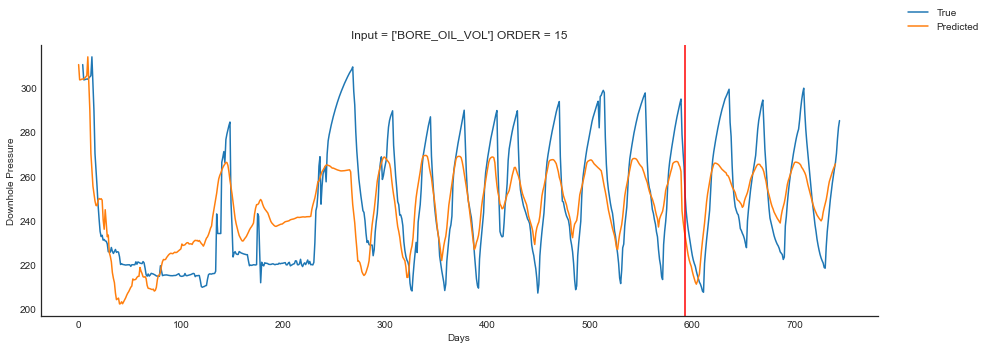

#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  1.5677183777447459
R2:  -0.06019
#####################################################################
 Order Selected:     5
RMSE:  1.6454530550260595
R2:  0.19613
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = s

RMSE:  1.4373344842451403
R2:  0.23797
#####################################################################
 Order Selected:     15
RMSE:  1.26285209795285
R2:  0.32518
#####################################################################
 Order Selected:     20
RMSE:  1.2625506155376518
R2:  0.3319


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,2.521880,-0.103273,False
3,4,2.457741,-0.060185,False
4,5,2.707516,0.196131,False
5,10,2.065930,0.237970,False
6,15,1.594795,0.325180,False
7,20,1.594034,0.331896,True


0.33189605759116314 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E2205F3CA0> 20
   Regressors   Parameters             ERR
0      y(k-1)   1.2981E+00  9.99464499E-01
1      y(k-2)  -2.5283E-01  9.87281624E-05
2           1   1.3755E+01  1.17602463E-05
3      y(k-6)  -2.3349E-03  1.71207592E-05
4     x1(k-3)  -9.4610E-03  2.67260081E-06
5     y(k-20)   4.0736E-02  3.26855693E-06
6     y(k-14)  -1.5980E-01  9.43007561E-06
7    x1(k-19)  -1.0470E-02  1.17496576E-06
8    x1(k-18)   1.1563E-02  1.07024167E-06
9     x1(k-4)  -6.7236E-03  1.01158867E-06
10     y(k-3)  -1.1167E-01  1.10014039E-06
11    y(k-15)   1.3487E-01  1.21401666E-06
12    y(k-11)   9.5074E-03  1.26477363E-06
13   x1(k-14)  -7.3213E-03  9.27454625E-07
14     y(k-4)   1.0645E-01  6.88186963E-07
15     y(k-5)  -7.7571E-02  7.49095502E-07
16    y(k-16)  -8.8423E-02  7.00362902E-07
17    y(k-17)   4.1008E-02  4.77672938E-07
18     y(k-9)  -6.4754E-02  3.62649942E-07

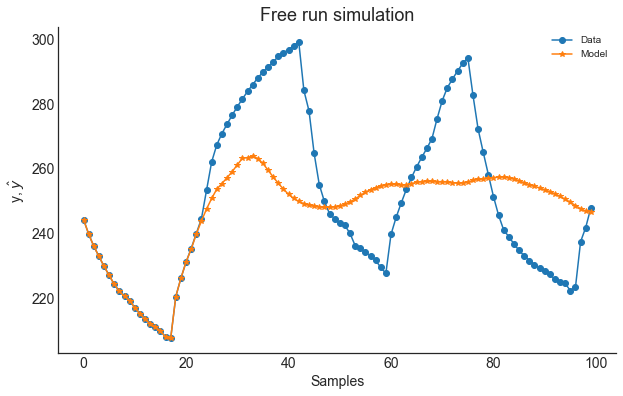

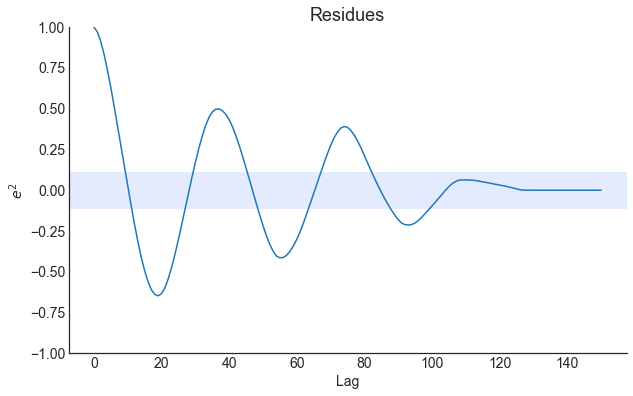

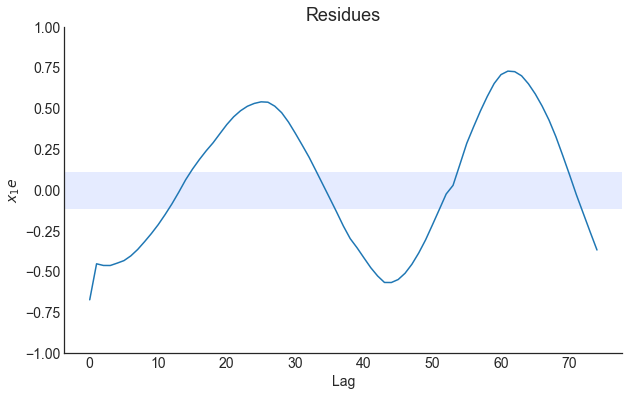

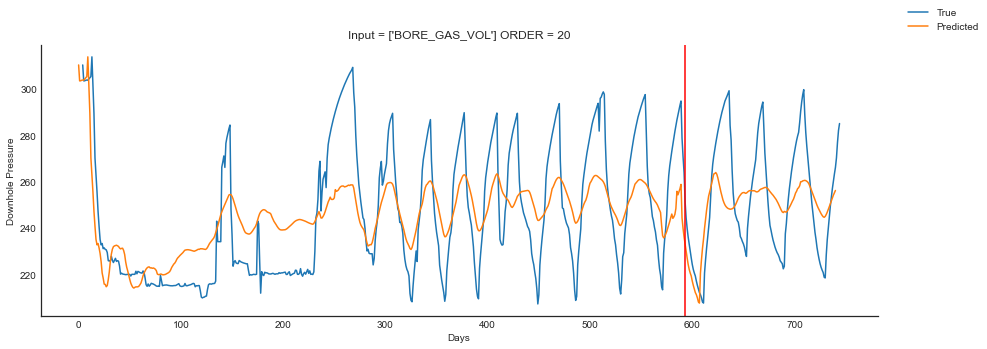

#####################################################################
FEATURES SELECTED =  ['BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.9800337785556814
R2:  -0.1543
#####################################################################
 Order Selected:     5
RMSE:  0.9885358553095693
R2:  0.07311
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = s

RMSE:  0.9442433388806005
R2:  0.4732
#####################################################################
 Order Selected:     15
RMSE:  0.7650426190230658
R2:  0.69081
#####################################################################
 Order Selected:     20
RMSE:  0.697616704976007
R2:  0.74608


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,2.521880,-0.103273,False
3,4,0.960466,-0.154296,False
4,5,0.977203,0.073110,False
5,10,0.891595,0.473197,False
6,15,0.585290,0.690814,False
7,20,0.486669,0.746084,True


0.746084415153035 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E220B7D220> 20
   Regressors   Parameters             ERR
0      y(k-1)   1.2049E+00  9.99464499E-01
1      y(k-2)  -2.1965E-01  9.87281624E-05
2    x1(k-14)   2.6930E-03  3.67266737E-05
3     x1(k-1)  -5.0343E-03  6.83247457E-06
4           1   6.2001E+00  1.54194493E-05
5     x1(k-8)   2.3221E-03  3.64323286E-06
6    x1(k-19)   1.5369E-03  3.92225228E-06
7     y(k-10)   9.7488E-02  2.52753307E-06
8    x1(k-17)   2.2021E-03  1.72713803E-06
9    x1(k-11)   1.0383E-03  5.27254179E-07
10     y(k-9)  -8.2138E-02  3.43535228E-07
11     y(k-8)   5.0727E-02  4.92380728E-07
12    y(k-14)  -1.0577E-01  3.94881346E-07
13    y(k-15)   8.5706E-02  2.41335207E-06
14     y(k-3)  -8.8451E-02  5.02187199E-07
15    x1(k-5)  -1.0573E-03  4.66005198E-07
16   x1(k-15)  -1.3464E-03  4.43783329E-07
17   x1(k-18)   9.5406E-04  3.24239472E-07
18     y(k-4)   8.2525E-02  2.79393914E-07
1

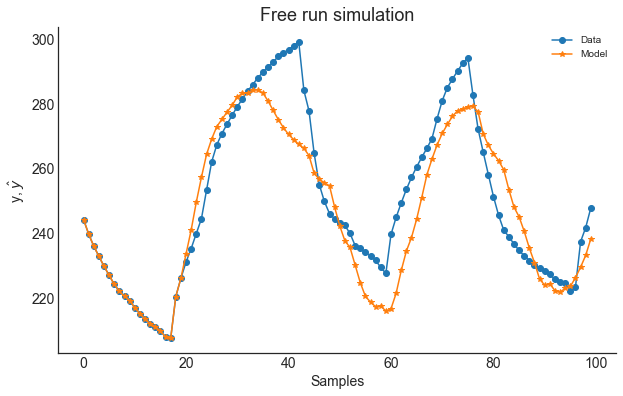

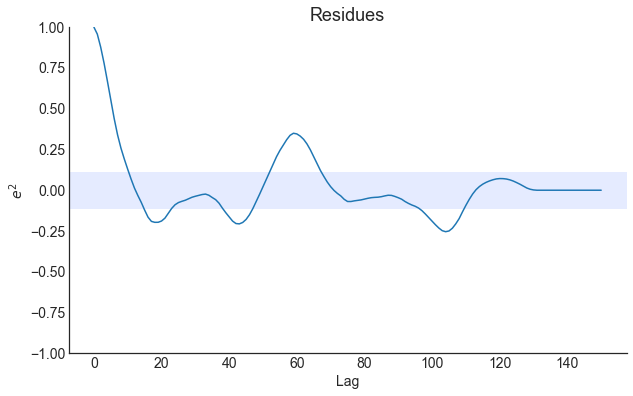

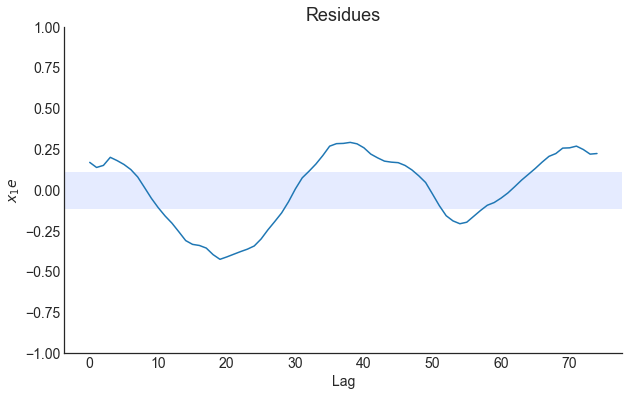

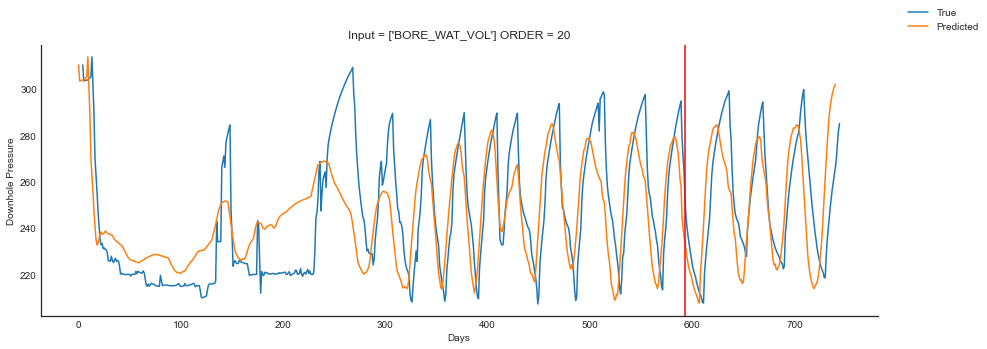

#####################################################################
FEATURES SELECTED =  ['AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5
RMSE:  0.6043134129200215
R2:  0.90662
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = s

RMSE:  0.5364031025690282
R2:  0.92435
#####################################################################
 Order Selected:     15
RMSE:  0.5454851478242618
R2:  0.92244
#####################################################################
 Order Selected:     20
RMSE:  0.5552835361246083
R2:  0.91215


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,2.521880,-0.103273,False
3,4,0.342944,0.909993,False
4,5,0.365195,0.906619,False
5,10,0.287728,0.924350,True
6,15,0.297554,0.922437,False
7,20,0.308340,0.912147,False


0.9243501662220599 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E22047EE50> 10
  Regressors   Parameters             ERR
0     y(k-1)   9.8255E-01  9.99448945E-01
1     y(k-2)  -1.6929E-01  1.06990868E-04
2   x1(k-15)  -9.9740E-03  1.59547788E-05
3    x1(k-1)  -2.2174E-01  1.75726216E-05
4          1   4.9107E+01  5.03036381E-05
5    x1(k-2)  -1.4261E-02  6.41223600E-06
6    x1(k-3)   1.2798E-01  8.35716067E-06
7    y(k-10)  -8.1644E-02  3.80999118E-06
8    x1(k-6)  -3.2575E-02  1.86030325E-06
9   x1(k-18)   1.5098E-02  7.38463513E-07


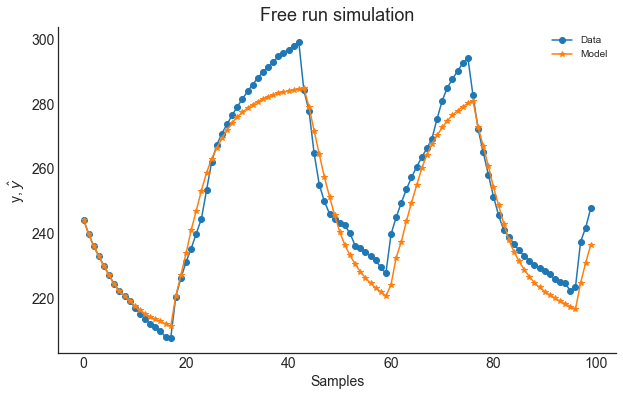

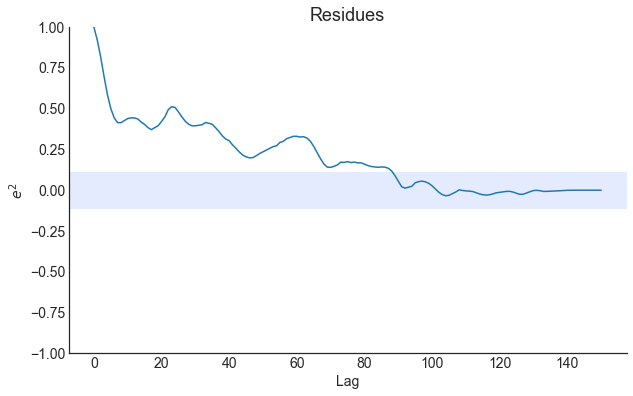

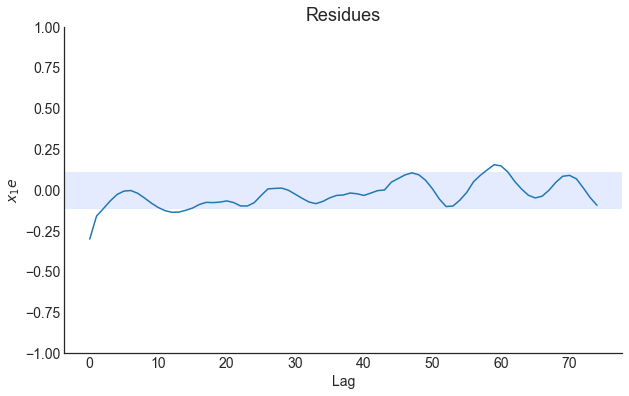

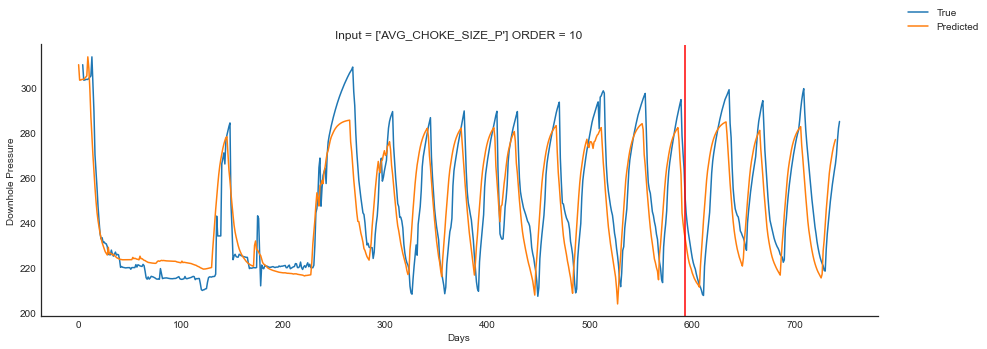

#####################################################################
FEATURES SELECTED =  ['ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = s

RMSE:  0.5638891033818928
R2:  0.9119
#####################################################################
 Order Selected:     15
RMSE:  0.5606746840646912
R2:  0.91304
#####################################################################
 Order Selected:     20
RMSE:  0.5672000105221523
R2:  0.90418


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,2.521880,-0.103273,False
3,4,0.351798,0.905414,False
4,5,0.363055,0.907010,False
5,10,0.317971,0.911900,False
6,15,0.314356,0.913037,True
7,20,0.321716,0.904175,False


0.9130365877773655 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E2209D5FD0> 15
   Regressors   Parameters             ERR
0      y(k-1)   9.6704E-01  9.99464631E-01
1      y(k-2)  -7.3976E-02  1.00881450E-04
2    x1(k-15)   6.5495E-02  3.12625426E-05
3     x1(k-1)  -5.1284E-01  1.61183378E-05
4           1   4.4887E+01  4.07157437E-05
5     x1(k-2)   3.6079E-01  1.06941088E-05
6     x1(k-4)  -6.9820E-02  6.24961761E-06
7    x1(k-10)  -9.0949E-02  2.40843372E-06
8     y(k-15)   7.9488E-02  1.70477536E-06
9    x1(k-19)  -3.3629E-02  1.78329532E-06
10    x1(k-6)  -7.4673E-02  1.12674997E-06
11     y(k-5)  -1.2233E-01  1.27099353E-06
12   x1(k-11)  -7.7374E-02  2.09509524E-06
13    y(k-14)   6.4924E-02  1.30469252E-06
14    y(k-12)  -8.4449E-02  1.84606022E-06


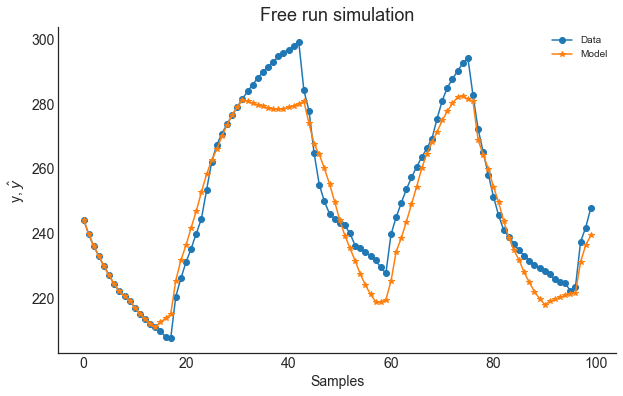

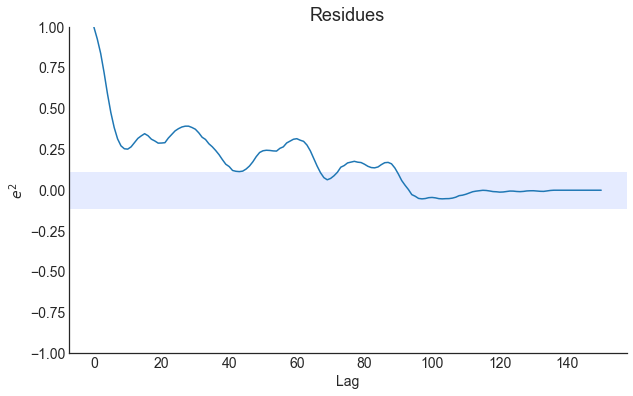

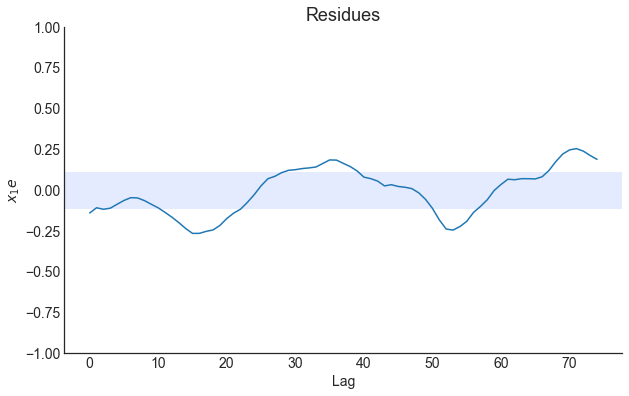

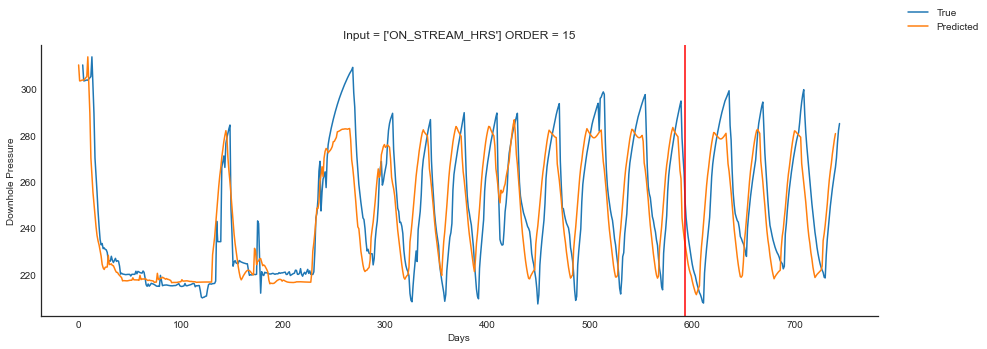

In [9]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [1,2,3,4,5,10,15,20]

for feature in np.arange(2,8):
    
    r2_best = 0
    history = []
    results_ = pd.DataFrame()

    X_inputs = inputs_selection([feature])
    #best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']

    train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
    train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
    print('#####################################################################')
    print('FEATURES SELECTED = ', inputs_selection([feature]))
    print('#####################################################################')
    
    for order in tqdm(n_order):
    
        print('#####################################################################')
        print(' Order Selected:    ',order)                


        basis_function = Polynomial(degree=1)

        lag = list(range(1,order+1))
        model = FROLS(
            order_selection=True,
            n_terms=order,
            extended_least_squares=False,
            ylag=order, xlag=order,
            info_criteria='bic',
            estimator='least_squares',
            basis_function=basis_function
        )

        model.fit(X = train_X, y = train_y)

        yhat = model.predict(X=test_X, y=test_y)
        
        try:
            r2 = r2_score(test_y, yhat)
            rrse = root_relative_squared_error(test_y, yhat)
        except:
            print('MODEL FAILED')
            r2 = 0
            rrse = 0
            pass
        
        print('RMSE: ',rrse)
        print('R2: ',round(r2,5))


        history.append([order,rrse,r2])

        if r2 > r2_best:      
            r2_best = r2
            best_model = model
            best_order = order

    History = pd.DataFrame(history, columns = ['Order','RMSE','R2'])
    History['Best'] = (History['R2'] == r2_best)

    display(History)

    print(r2_best,best_model,best_order)

    yhat = best_model.predict(X=test_X, y=test_y)
    
    
    results_ = pd.DataFrame(
        results(
            model.final_model, best_model.theta, best_model.err,
            best_model.n_terms, err_precision=8, dtype='sci'),
        columns=['Regressors', 'Parameters', 'ERR'])
    print(results_)
    
    plot_results(y=test_y, yhat = yhat)

    ee = compute_residues_autocorrelation(test_y, yhat)
    plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
    x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
    plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

    results_sysid = []
    results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

    fig,ax1 = plt.subplots(figsize=(15, 5))
    ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
    ax1.plot(results_sysid, label = 'Predicted')
    ax1.axvline(x=train_index,color = 'r')
    ax1.set_title(f'Input = {inputs_selection([feature])} ORDER = {best_order}',)
    ax1.set_ylabel('Downhole Pressure')
    ax1.set_xlabel('Days')

    fig.legend( loc = 'upper right')
    plt.show()


(2, 3)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2: 

C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


 -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5
RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5778479446306994
R2:  0.92373
#####################################################################
 Order Selected:     15
RMSE:  0.5187012941297888
R2:  0.94393
#####################################################################
 Order Selected:     20
RMSE:  0.5359205939387945
R2:  0.93738
(2, 4)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6172789529910528
R2:  0.89415
#####################################################################
 Order Selected:     10
RMSE:  0.5999201512770354
R2:  0.90646
#####################################################################
 Order Selected:     15
RMSE:  0.5649196555327405
R2:  0.91532
#####################################################################
 Order Selected:     20
RMSE:  0.5615644277618108
R2:  0.91167
(2, 5)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6382249223094155
R2:  0.85852
#####################################################################
 Order Selected:     10
RMSE:  0.6390967237945482
R2:  0.84914
#####################################################################
 Order Selected:     15
RMSE:  0.5730066058852422
R2:  0.90088
#####################################################################
 Order Selected:     20
RMSE:  0.5745005138255265
R2:  0.8906
(2, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5
RMSE:  0.5787976411512309
R2:  0.91011
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5253469058124868
R2:  0.92945
#####################################################################
 Order Selected:     15
RMSE:  0.516956758496887
R2:  0.93299
#####################################################################
 Order Selected:     20
RMSE:  0.5292977921938844
R2:  0.92499
(2, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.541494146000797
R2:  0.92457
#####################################################################
 Order Selected:     15
RMSE:  0.5475313148766784
R2:  0.91812
#####################################################################
 Order Selected:     20
RMSE:  0.5512365680580358
R2:  0.9109
(3, 4)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  1.2526679096835887
R2:  0.53042
#####################################################################
 Order Selected:     5
RMSE:  1.2307447143736627
R2:  0.56686
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  1.1394185821578642
R2:  0.60743
#####################################################################
 Order Selected:     15
RMSE:  0.9989958262659914
R2:  0.66403
#####################################################################
 Order Selected:     20
RMSE:  0.993181137867396
R2:  0.65437
(3, 5)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  1.2526679096835887
R2:  0.53042
#####################################################################
 Order Selected:     5
RMSE:  0.812184972250518
R2:  0.7611
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.7677162379963808
R2:  0.81255
#####################################################################
 Order Selected:     15
RMSE:  0.6957463356818945
R2:  0.82843
#####################################################################
 Order Selected:     20
RMSE:  0.6806177101413037
R2:  0.83011
(3, 6)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5427202103371798
R2:  0.93566
#####################################################################
 Order Selected:     10
RMSE:  0.5107361742839389
R2:  0.94489
#####################################################################
 Order Selected:     15
RMSE:  0.507304812010481
R2:  0.94479
#####################################################################
 Order Selected:     20
RMSE:  0.5196415824957785
R2:  0.93708
(3, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5582483292458996
R2:  0.91809
#####################################################################
 Order Selected:     15
RMSE:  0.5500581895473812
R2:  0.9218
#####################################################################
 Order Selected:     20
RMSE:  0.5515314036429715
R2:  0.91648
(4, 5)
#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL', 'BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.9800337785556814
R2:  -0.1543
#####################################################################
 Order Selected:     5
RMSE:  0.8753605878100461
R2:  0.50818
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.8052062650667563
R2:  0.73735
#####################################################################
 Order Selected:     15
RMSE:  0.7026833000361323
R2:  0.80225
#####################################################################
 Order Selected:     20
RMSE:  0.6637252088569792
R2:  0.80518
(4, 6)
#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5
RMSE:  0.6043134129200215
R2:  0.90662
#####################################################################
 Order Selected:    

C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


 10
RMSE:  0.527518528914567
R2:  0.93187
#####################################################################
 Order Selected:     15
RMSE:  0.5202758335494455
R2:  0.93938
#####################################################################
 Order Selected:     20
RMSE:  0.5086276486901848
R2:  0.93977
(4, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.577395893424078
R2:  0.89589
#####################################################################
 Order Selected:     15
RMSE:  0.5606746840646912
R2:  0.91304
#####################################################################
 Order Selected:     20
RMSE:  0.5582543915150604
R2:  0.91023
(5, 6)
#####################################################################
FEATURES SELECTED =  ['BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6043134129200215
R2:  0.90662
#####################################################################
 Order Selected:     10
RMSE:  0.5303002242172905
R2:  0.93025
#####################################################################
 Order Selected:     15
RMSE:  0.5327943669678626
R2:  0.92917
#####################################################################
 Order Selected:     20
RMSE:  0.5350267628805113
R2:  0.92217
(5, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5857703832449063
R2:  0.89112
#####################################################################
 Order Selected:     15
RMSE:  0.5741672771610467
R2:  0.89803
#####################################################################
 Order Selected:     20
RMSE:  0.5917800542659786
R2:  0.87905
(6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5483716520380195
R2:  0.92021
#####################################################################
 Order Selected:     15
RMSE:  0.5648694558129651
R2:  0.91192
#####################################################################
 Order Selected:     20
RMSE:  0.5733331478518398
R2:  0.89911
(2, 3, 4)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5778479446306994
R2:  0.92373
#####################################################################
 Order Selected:     15
RMSE:  0.5283511114627188
R2:  0.93804
#####################################################################
 Order Selected:     20
RMSE:  0.5414423305934628
R2:  0.9322
(2, 3, 5)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5814863827984866
R2:  0.91025
#####################################################################
 Order Selected:     15
RMSE:  0.5451663764555195
R2:  0.92096
#####################################################################
 Order Selected:     20
RMSE:  0.5481028824588099
R2:  0.91577
(2, 3, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5263716211127839
R2:  0.94154
#####################################################################
 Order Selected:     15
RMSE:  0.481822417052197
R2:  0.95372
#####################################################################
 Order Selected:     20
RMSE:  0.4889188130677641
R2:  0.95061
(2, 3, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE: 

C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


 0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.541494146000797
R2:  0.92457
#####################################################################
 Order Selected:     15
RMSE:  0.5301023302611726
R2:  0.93121
#####################################################################
 Order Selected:     20
RMSE:  0.5334602576776027
R2:  0.92623
(2, 4, 5)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5
RMSE:  0.6382249223094155
R2:  0.85852
#####################################################################
 Order Selected:     10
RMSE:  0.6125097495569163
R2:  0.88105
#####################################################################
 Order Selected:     15
RMSE:  0.5782682217680203
R2:  0.8933
#####################################################################
 Order Selected:     20
RMSE:  0.5652876998422215
R2:  0.89496
(2, 4, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5787976411512309
R2:  0.91011
#####################################################################
 Order Selected:     10
RMSE:  0.5253469058124868
R2:  0.92945
#####################################################################
 Order Selected:     15
RMSE:  0.49779895210134006
R2:  0.94386
#####################################################################
 Order Selected:     20
RMSE:  0.4865714993510177
R2:  0.94724
(2, 4, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.541494146000797
R2:  0.92457
#####################################################################
 Order Selected:     15
RMSE:  0.5475313148766784
R2:  0.91812
#####################################################################
 Order Selected:     20
RMSE:  0.5518974015896649
R2:  0.91156
(2, 5, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5787976411512309
R2:  0.91011
#####################################################################
 Order Selected:     10
RMSE:  0.5477601391411354
R2:  0.91846
#####################################################################
 Order Selected:     15
RMSE:  0.5043121832986327
R2:  0.93928
#####################################################################
 Order Selected:     20
RMSE:  0.5328057378882265
R2:  0.91892
(2, 5, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.5721185158241525
R2:  0.89016
#####################################################################
 Order Selected:     20
RMSE:  0.5857997843279004
R2:  0.86905
(2, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5313636594986194
R2:  0.92757
#####################################################################
 Order Selected:     15
RMSE:  0.5391990942734727
R2:  0.9215
#####################################################################
 Order Selected:     20
RMSE:  0.5627084229865328
R2:  0.90396
(3, 4, 5)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  1.2526679096835887
R2:  0.53042
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.812184972250518
R2:  0.7611
#####################################################################
 Order Selected:     10
RMSE:  0.7580259983222652
R2:  0.81046
#####################################################################
 Order Selected:     15
RMSE:  0.6847801540784548
R2:  0.84102
#####################################################################
 Order Selected:     20
RMSE:  0.6631604519633497
R2:  0.83971
(3, 4, 6)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5427202103371798
R2:  0.93566
#####################################################################
 Order Selected:     10
RMSE:  0.5107361742839389
R2:  0.94489
#####################################################################
 Order Selected:     15
RMSE:  0.5124690921590142
R2:  0.94444
#####################################################################
 Order Selected:     20
RMSE:  0.5181249389212991
R2:  0.93936
(3, 4, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.577395893424078
R2:  0.89589
#####################################################################
 Order Selected:     15
RMSE:  0.5605987882764153
R2:  0.91288
#####################################################################
 Order Selected:     20
RMSE:  0.5541004520830395
R2:  0.91371
(3, 5, 6)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5427202103371798
R2:  0.93566
#####################################################################
 Order Selected:     10
RMSE:  0.518611773867511
R2:  0.93933
#####################################################################
 Order Selected:     15
RMSE:  0.5148229082057981
R2:  0.94173
#####################################################################
 Order Selected:     20
RMSE:  0.53225584575238
R2:  0.931
(3, 5, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5596653929468349
R2:  0.91252
#####################################################################
 Order Selected:     15
RMSE:  0.5687053560009201
R2:  0.90187
#####################################################################
 Order Selected:     20
RMSE:  0.5797579580712734
R2:  0.89375
(3, 6, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5300534937413186
R2:  0.93476
#####################################################################
 Order Selected:     15
RMSE:  0.5498958200383359
R2:  0.92262
#####################################################################
 Order Selected:     20
RMSE:  0.5659728967060231
R2:  0.90782
(4, 5, 6)
#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6043134129200215
R2:  0.90662
#####################################################################
 Order Selected:     10
RMSE:  0.5303002242172905
R2:  0.93025
#####################################################################
 Order Selected:     15
RMSE:  0.5319252413276584
R2:  0.93076
#####################################################################
 Order Selected:     20
RMSE:  0.5308459043523284
R2:  0.92766
(4, 5, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL', 'BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5857703832449063
R2:  0.89112
#####################################################################
 Order Selected:     15
RMSE:  0.5730553460756125
R2:  0.89835
#####################################################################
 Order Selected:     20
RMSE:  0.5876184151886736
R2:  0.88099
(4, 6, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5483716520380195
R2:  0.92021
#####################################################################
 Order Selected:     15
RMSE:  0.575024183562119
R2:  0.90238
#####################################################################
 Order Selected:     20
RMSE:  0.5730413726811314
R2:  0.8991
(5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 9 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5608716115349839
R2:  0.90817
#####################################################################
 Order Selected:     15
RMSE:  0.5881534082952508
R2:  0.88734
#####################################################################
 Order Selected:     20
RMSE:  0.6183742556667723
R2:  0.85304
(2, 3, 4, 5)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5814863827984866
R2:  0.91025
#####################################################################
 Order Selected:     15
RMSE:  0.5523940762450437
R2:  0.91682
#####################################################################
 Order Selected:     20
RMSE:  0.5563976878073477
R2:  0.90681
(2, 3, 4, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5263716211127839
R2:  0.94154
#####################################################################
 Order Selected:     15
RMSE:  0.481822417052197
R2:  0.95372
#####################################################################
 Order Selected:     20
RMSE:  0.4959505112495046
R2:  0.94749
(2, 3, 4, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.541494146000797
R2:  0.92457
#####################################################################
 Order Selected:     15
RMSE:  0.5387984051596353
R2:  0.9221
#####################################################################
 Order Selected:     20
RMSE:  0.5365931319549063
R2:  0.92462
(2, 3, 5, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088
R2:  0.88417


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


#####################################################################
 Order Selected:     5
RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5183056605740863
R2:  0.9381
#####################################################################
 Order Selected:     15
RMSE:  0.4998265155260248
R2:  0.94032
#####################################################################
 Order Selected:     20
RMSE:  0.5154898985916573
R2:  0.93701
(2, 3, 5, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.5566895999269551
R2:  0.90404
#####################################################################
 Order Selected:     20
RMSE:  0.5824487844250864
R2:  0.88041
(2, 3, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5313636594986194
R2:  0.92757
#####################################################################
 Order Selected:     15
RMSE:  0.5364830491256395
R2:  0.92396
#####################################################################
 Order Selected:     20
RMSE:  0.5555856152933822
R2:  0.91649
(2, 4, 5, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.6346559406792088

C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)



R2:  0.88417
#####################################################################
 Order Selected:     5
RMSE:  0.5787976411512309
R2:  0.91011
#####################################################################
 Order Selected:     10
RMSE:  0.5477601391411354
R2:  0.91846
#####################################################################
 Order Selected:     15
RMSE:  0.4967147795727719
R2:  0.94513
#####################################################################
 Order Selected:     20
RMSE:  0.5483017879949219
R2:  0.90927
(2, 4, 5, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.5721185158241525
R2:  0.89016
#####################################################################
 Order Selected:     20
RMSE:  0.5996595426927969
R2:  0.86201
(2, 4, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5313636594986194
R2:  0.92757
#####################################################################
 Order Selected:     15
RMSE:  0.5391990942734727
R2:  0.9215
#####################################################################
 Order Selected:     20
RMSE:  0.5785354622609957
R2:  0.89292
(2, 5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.5838279703199744
R2:  0.88201
#####################################################################
 Order Selected:     20
RMSE:  0.6080766423608269
R2:  0.85154
(3, 4, 5, 6)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5856145963135092
R2:  0.90999
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5427202103371798
R2:  0.93566
#####################################################################
 Order Selected:     10
RMSE:  0.518611773867511
R2:  0.93933
#####################################################################
 Order Selected:     15
RMSE:  0.5179476892923857
R2:  0.93798
#####################################################################
 Order Selected:     20
RMSE:  0.5263675156747021
R2:  0.93131
(3, 4, 5, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5596653929468349
R2:  0.91252
#####################################################################
 Order Selected:     15
RMSE:  0.5687053560009201
R2:  0.90187
#####################################################################
 Order Selected:     20
RMSE:  0.5876184151886736
R2:  0.88099
(3, 4, 6, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5207852927973238
R2:  0.93727
#####################################################################
 Order Selected:     15
RMSE:  0.5606779996586322
R2:  0.91457
#####################################################################
 Order Selected:     20
RMSE:  0.5637350031534714
R2:  0.90976
(3, 5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5439404013139554
R2:  0.92176
#####################################################################
 Order Selected:     15
RMSE:  0.5234139490555896
R2:  0.93177
#####################################################################
 Order Selected:     20
RMSE:  0.6154304399319882
R2:  0.86483
(4, 5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4
RMSE: 

C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


 0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5608716115349839
R2:  0.90817
#####################################################################
 Order Selected:     15
RMSE:  0.5927360659601099
R2:  0.88287
#####################################################################
 Order Selected:     20
RMSE:  0.6005619601853048
R2:  0.86809
(2, 3, 4, 5, 6)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.6346559406792088
R2:  0.88417
#####################################################################
 Order Selected:     5
RMSE:  0.6145674560533398
R2:  0.91055
#####################################################################
 Order Selected:     10
RMSE:  0.5183056605740863
R2:  0.9381
#####################################################################
 Order Selected:     15
RMSE:  0.5035180991430436
R2:  0.94018
#####################################################################
 Order Selected:     20
RMSE:  0.516480087387106
R2:  0.93607
(2, 3, 4, 5, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.5566895999269551
R2:  0.90404
#####################################################################
 Order Selected:     20
RMSE:  0.5996595426927969
R2:  0.86201
(2, 3, 4, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5313636594986194
R2:  0.92757
#####################################################################
 Order Selected:     15
RMSE:  0.5364830491256395
R2:  0.92396
#####################################################################
 Order Selected:     20
RMSE:  0.5371270401057161
R2:  0.92583
(2, 3, 5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.579925056920591
R2:  0.88916
#####################################################################
 Order Selected:     20
RMSE:  0.6083308465597953
R2:  0.86144
(2, 4, 5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.5838279703199744
R2:  0.88201
#####################################################################
 Order Selected:     20
RMSE:  0.6200749915111796
R2:  0.84018
(3, 4, 5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5439404013139554
R2:  0.92176
#####################################################################
 Order Selected:     15
RMSE:  0.5234139490555896
R2:  0.93177
#####################################################################
 Order Selected:     20
RMSE:  0.6108351725212458
R2:  0.86866
(2, 3, 4, 5, 6, 7)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P', 'ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.5880429218614318
R2:  -0.10327
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 8 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.5931254138873794
R2:  0.90541
#####################################################################
 Order Selected:     5
RMSE:  0.602540084235288
R2:  0.90701
#####################################################################
 Order Selected:     10
RMSE:  0.5808040998477327
R2:  0.88584
#####################################################################
 Order Selected:     15
RMSE:  0.579925056920591
R2:  0.88916
#####################################################################
 Order Selected:     20
RMSE:  0.6200749915111796
R2:  0.84018


,Combination Number,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,NaN,False
1,2,1.237651,-2.230956,NaN,False
2,3,2.521880,-0.103273,NaN,False
3,4,0.351798,0.905414,NaN,False
4,5,0.363055,0.907010,NaN,False
...,...,...,...,...,...
459,"(2, 3, 4, 5, 6, 7)",4.000000,0.351798,0.905414,False
460,"(2, 3, 4, 5, 6, 7)",5.000000,0.363055,0.907010,False
461,"(2, 3, 4, 5, 6, 7)",10.000000,0.337333,0.885842,False
462,"(2, 3, 4, 5, 6, 7)",15.000000,0.336313,0.889162,False


0.9537162804593318 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E2207AB760> 15
  Regressors   Parameters             ERR
0     y(k-1)   9.6317E-01  9.99454016E-01
1     y(k-2)  -7.9049E-02  1.05713822E-04
2   x4(k-14)   3.2943E+01  1.33653343E-05
3   x5(k-18)  -5.3997E-01  7.74187873E-05
4    x4(k-8)   2.1305E-01  8.92157157E-06


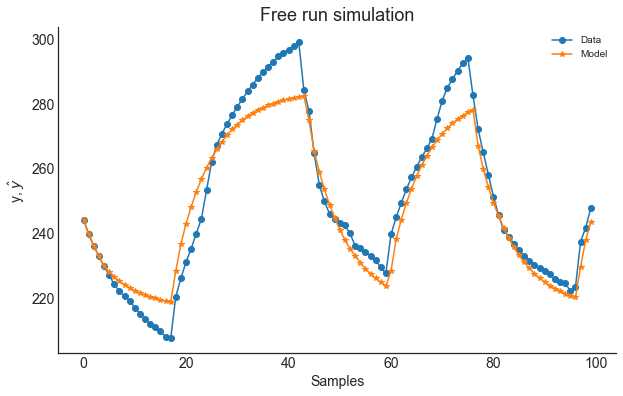

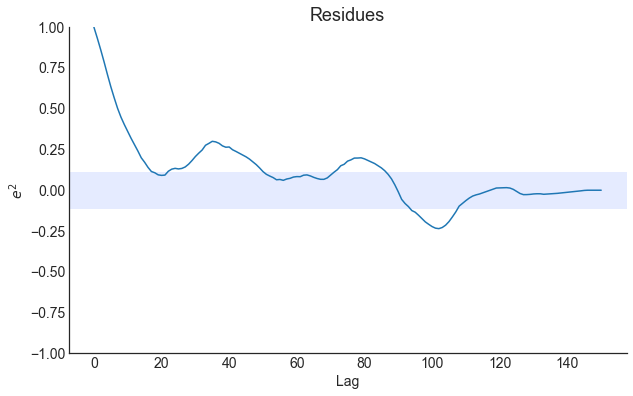

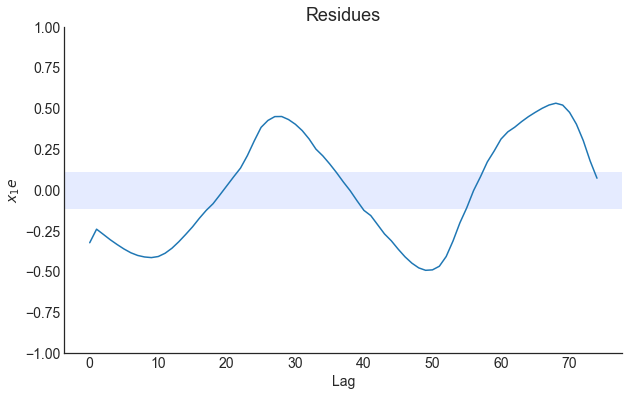

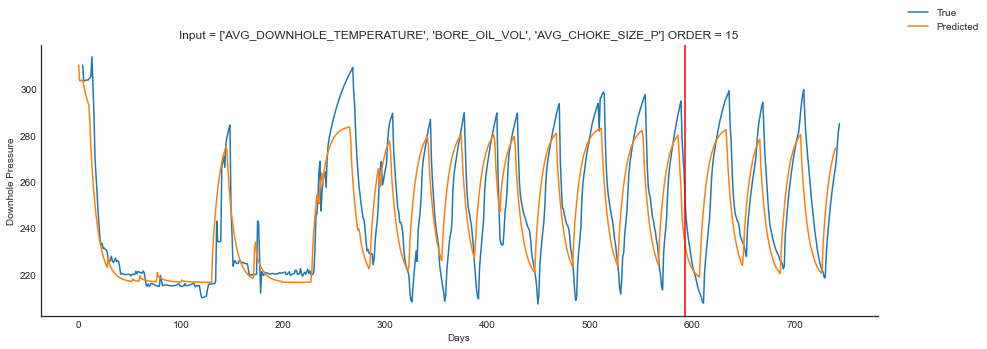

In [10]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [1,2,3,4,5,10,15,20]

combinations_= []
feature = np.arange(2,8)
for L in range(2, len(feature)+1):
    for subset in itertools.combinations(feature, L):
        #X_inputs = inputs_selection([subset])
        combinations_.append(subset)

r2_best = 0

for feature in combinations_:
    print(feature)

    X_inputs = inputs_selection(feature)
    #best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']
    
    feature_r2_best = 0
    
    results_ = pd.DataFrame()
    
    train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
    train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
    
    print('#####################################################################')
    print('FEATURES SELECTED = ', inputs_selection(feature))
    print('#####################################################################')
    
    for order in tqdm(n_order):
        
        print('#####################################################################')
        print(' Order Selected:    ',order)                


        basis_function = Polynomial(degree=1)

        lag = list(range(1,order+1))
        model = FROLS(
            order_selection=True,
            n_terms=order,
            extended_least_squares=False,
            ylag=order, xlag=[lag]*len(feature),
            info_criteria='bic',
            estimator='least_squares',
            basis_function=basis_function
        )

        model.fit(X = train_X, y = train_y)

        yhat = model.predict(X=test_X, y=test_y)
        
        try:
            r2 = r2_score(test_y, yhat)
            rrse = root_relative_squared_error(test_y, yhat)
        except:
            print('MODEL FAILED')
            r2 = 0
            rrse = 0
            pass
        
        print('RMSE: ',rrse)
        print('R2: ',round(r2,5))
        
        history.append([feature,order,rrse,r2])


        if r2 > feature_r2_best:      
            feature_r2_best = r2
            feature_rrse_best = rrse
            best_model = model
            feature_best_order = order

        
            
        if r2 > r2_best:      
            r2_best = feature_r2_best
            rrse_best = feature_rrse_best
            best_model = model
            best_order = order
            best_inputs = inputs_selection(feature)
            
    
History = pd.DataFrame(history, columns = ['Combination Number','Order','RMSE','R2'])
History['Best'] = (History['R2'] == r2_best)

display(History)

print(r2_best,best_model,best_order)

yhat = best_model.predict(X=test_X, y=test_y)


results_ = pd.DataFrame(
    results(
        model.final_model, best_model.theta, best_model.err,
        best_model.n_terms, err_precision=8, dtype='sci'),
    columns=['Regressors', 'Parameters', 'ERR'])
print(results_)

plot_results(y=test_y, yhat = yhat)

ee = compute_residues_autocorrelation(test_y, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

results_sysid = []
results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

fig,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
ax1.plot(results_sysid, label = 'Predicted')
ax1.axvline(x=train_index,color = 'r')
ax1.set_title(f'Input = {best_inputs} ORDER = {best_order}',)
ax1.set_ylabel('Downhole Pressure')
ax1.set_xlabel('Days')

fig.legend( loc = 'upper right')
plt.show()

History.to_excel("ARX_Output.xlsx")  

## NARX

#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.9623036876860598
R2:  0.64986
#####################################################################
 Order Selected:     5
RMSE:  0.6297262405438924
R2:  0.88832
#####################################################################
 Order Selected:     10
RMSE:  0.5398274214533322
R2:  0.93242
#####################################################################
 Order Selected:     15
RMSE:  0.6132360141168968
R2:  0.87715
#####################################################################
 Order Selected:     20
RMSE:  0.5929274200873668
R2:  0.89386


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,3.474012,0.024196,False
3,4,0.926028,0.649861,False
4,5,0.396555,0.888320,False
5,10,0.291414,0.932416,True
6,15,0.376058,0.877148,False
7,20,0.351563,0.893859,False


0.9324161620694148 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E2204FCEE0> 10
        Regressors   Parameters             ERR
0           y(k-1)   1.7478E+00  9.99448945E-01
1     y(k-9)y(k-3)  -2.0343E-04  1.18122702E-04
2    x1(k-1)y(k-2)  -4.7226E-03  2.76678247E-05
3         x1(k-14)   2.8276E-03  3.22163498E-05
4  x1(k-14)x1(k-1)  -6.4165E-03  3.63028911E-06
5    y(k-10)y(k-4)  -1.2218E-03  1.27654440E-05
6    x1(k-6)y(k-3)  -1.3461E-03  2.50160098E-06
7  x1(k-14)x1(k-9)   9.7906E-03  1.39371319E-06
8     y(k-9)y(k-7)  -4.3078E-03  2.63335743E-06
9    x1(k-5)y(k-7)  -1.5220E-03  2.45303039E-06


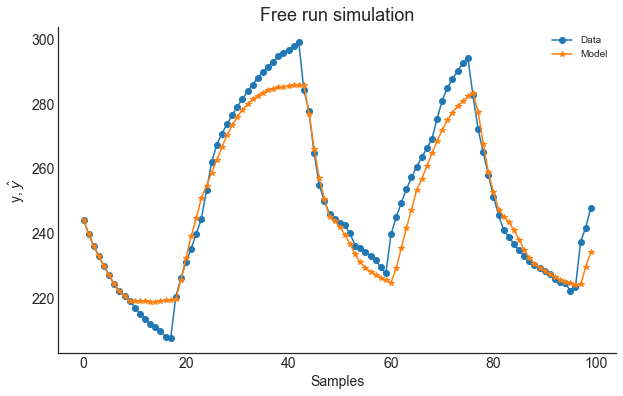

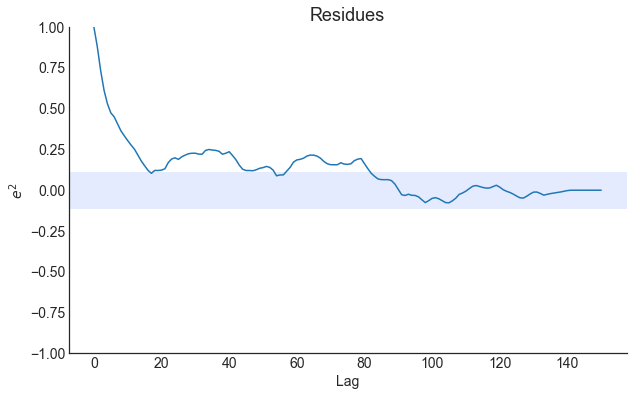

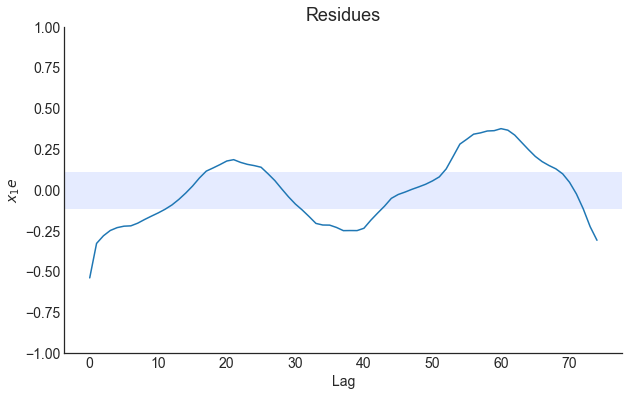

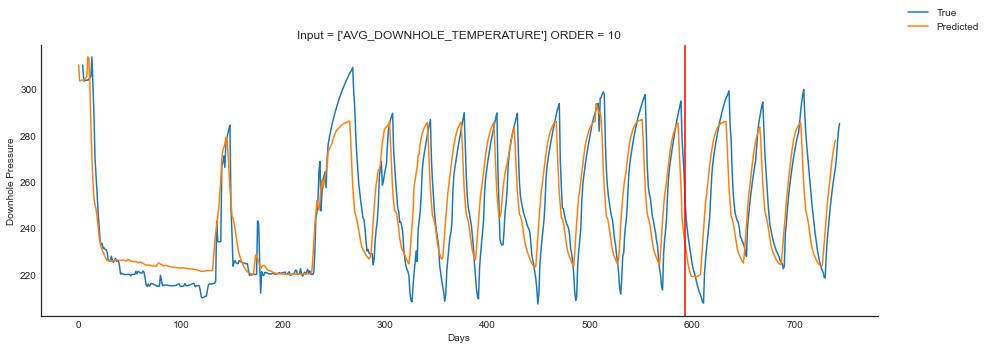

#####################################################################
FEATURES SELECTED =  ['BORE_OIL_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.677633578012308
R2:  0.87641
#####################################################################
 Order Selected:     15
RMSE:  0.7565683985666537
R2:  0.81999
#####################################################################
 Order Selected:     20
RMSE:  0.7102834057755963
R2:  0.84455


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,3.474012,0.024196,False
3,4,1.611934,0.511957,False
4,5,1.839621,0.497707,False
5,10,0.459187,0.876414,True
6,15,0.572396,0.819991,False
7,20,0.504503,0.844552,False


0.8764143628172397 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E220BB0BE0> 10
       Regressors   Parameters             ERR
0          y(k-1)   1.1273E+00  9.99448945E-01
1    y(k-9)y(k-3)  -2.1823E-04  1.18122702E-04
2          y(k-2)   1.6113E-04  2.60715311E-05
3   x1(k-1)y(k-1)  -8.4887E-04  2.29146377E-05
4   x1(k-2)y(k-9)   1.8753E-05  1.90713385E-05
5         y(k-20)   4.5047E-04  8.33892608E-06
6       x1(k-1)^2  -4.5138E-04  7.10814242E-06
7  x1(k-2)y(k-19)   9.1329E-04  2.59921944E-06
8          y(k-4)  -2.5775E-04  2.57856663E-06
9   y(k-14)y(k-5)  -3.1955E-04  2.14481523E-06


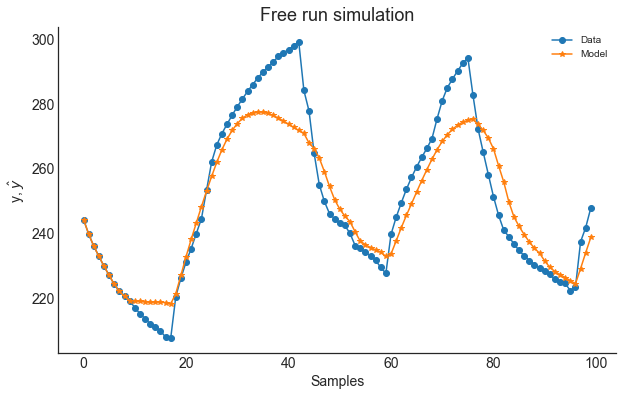

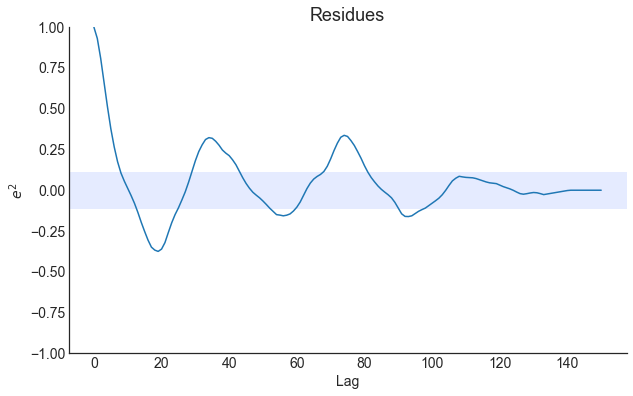

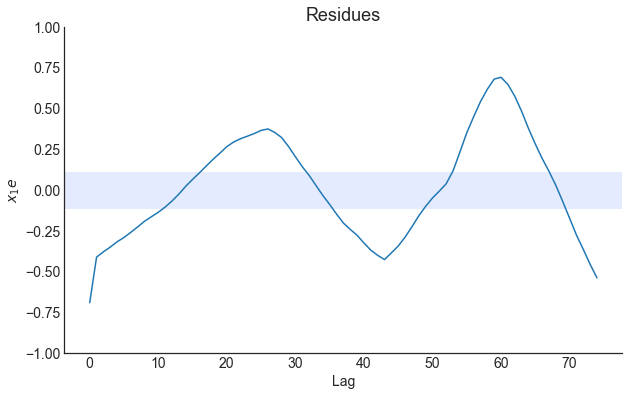

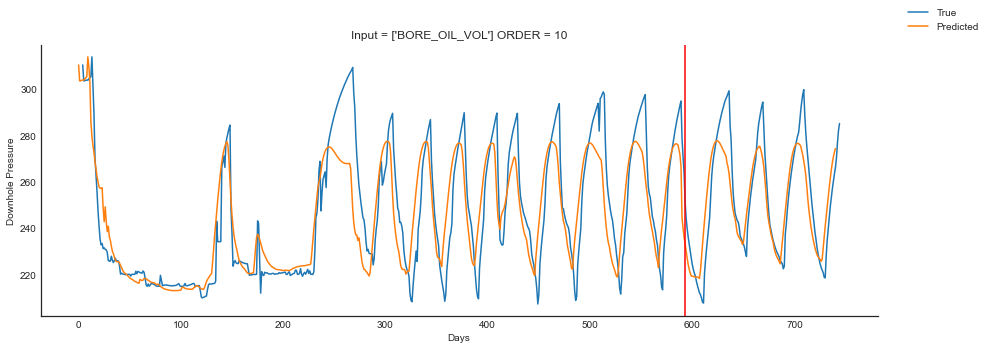

#####################################################################
FEATURES SELECTED =  ['BORE_GAS_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  1.74035506618697
R2:  0.23997
#####################################################################
 Order Selected:     5
RMSE:  1.2682643797203632
R2:  0.48006
#####################################################################
 Order Selected:     10
RMSE:  0.9087835247919196
R2:  0.70195
#####################################################################
 Order Selected:     15
RMSE:  0.7942332794123248
R2:  0.80312
#####################################################################
 Order Selected:     20
RMSE:  0.7054512608379951
R2:  0.83586


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,3.474012,0.024196,False
3,4,3.028836,0.239965,False
4,5,1.608495,0.480060,False
5,10,0.825887,0.701953,False
6,15,0.630807,0.803116,False
7,20,0.497661,0.835864,True


0.8358642454912741 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E220EE6280> 20
         Regressors   Parameters             ERR
0            y(k-1)  -2.9975E-01  9.99464499E-01
1      y(k-9)y(k-3)  -1.1649E-04  1.02605820E-04
2            y(k-2)   2.0083E-01  2.69641164E-05
3        x1(k-19)^2  -4.8814E-05  6.06996289E-06
4         x1(k-1)^2   3.8813E-04  5.56077436E-06
5           x1(k-1)  -5.3198E-01  1.10833418E-05
6          y(k-2)^2  -9.8364E-03  1.29042613E-05
7      y(k-2)y(k-1)   1.7827E-02  4.90603918E-06
8    x1(k-3)x1(k-2)   3.4282E-05  6.78448516E-06
9     x1(k-1)y(k-2)   7.9891E-03  5.99641082E-06
10  x1(k-19)x1(k-1)   6.3147E-04  8.27473326E-06
11                1   6.2095E+01  4.33426281E-06
12   x1(k-2)x1(k-1)   7.1139E-04  3.47933748E-06
13    x1(k-1)y(k-1)  -3.9425E-03  5.29921471E-06
14  x1(k-20)x1(k-5)  -1.7067E-04  2.57860955E-06
15    x1(k-1)y(k-3)  -2.7415E-03  1.94650449E-06
16           y(k-4)   8.031

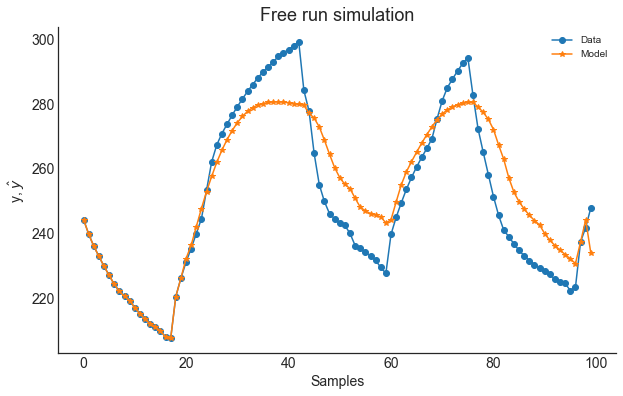

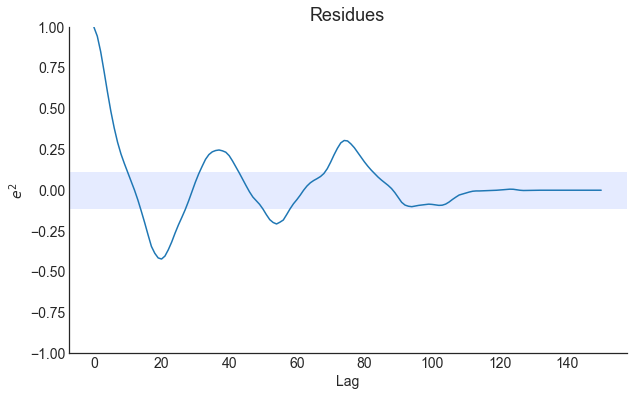

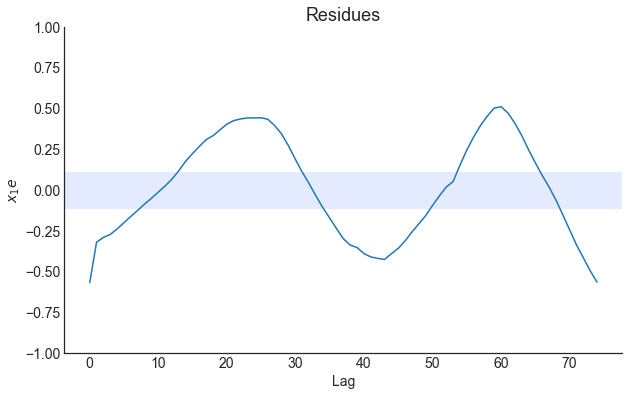

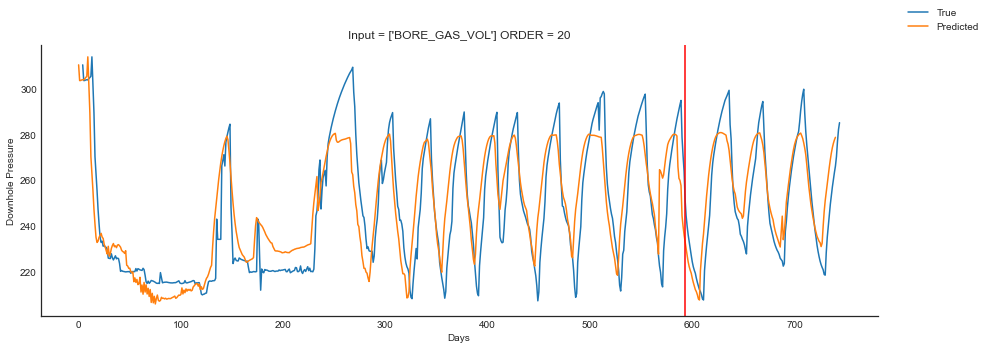

#####################################################################
FEATURES SELECTED =  ['BORE_WAT_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  1.0077406453814355
R2:  -0.00288
#####################################################################
 Order Selected:     5
RMSE:  0.9292486373428176
R2:  0.06147
#####################################################################
 Order Selected:     10
RMSE:  0.7893310010434104
R2:  0.67312
#####################################################################
 Order Selected:     15
RMSE:  0.8975342870498004
R2:  0.15833
#####################################################################
 Order Selected:     20
RMSE:  0.6879916047519962
R2:  0.75713


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,3.474012,0.024196,False
3,4,1.015541,-0.002881,False
4,5,0.863503,0.061475,False
5,10,0.623043,0.673119,False
6,15,0.805568,0.158333,False
7,20,0.473332,0.757129,True


0.7571289396126117 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E221179520> 20
         Regressors   Parameters             ERR
0            y(k-1)  -2.6965E-02  9.99464499E-01
1      y(k-9)y(k-3)  -5.4403E-03  1.02605820E-04
2            y(k-2)  -1.7317E-01  2.69641164E-05
3   x1(k-14)x1(k-8)   4.8161E-06  1.59661541E-05
4     x1(k-1)y(k-2)  -1.4025E-04  7.38245435E-06
5     x1(k-1)y(k-8)   2.5666E-04  1.46206031E-05
6          x1(k-17)   9.0891E-02  3.56157740E-06
7     y(k-10)y(k-4)   4.7312E-04  6.01006855E-06
8    x1(k-7)y(k-17)   6.2663E-05  2.72175720E-06
9   x1(k-15)x1(k-5)  -6.3721E-06  2.07797432E-06
10   x1(k-17)y(k-1)  -3.3144E-04  2.88500110E-06
11   x1(k-17)y(k-3)   1.7439E-04  4.83260356E-06
12  x1(k-17)x1(k-1)  -1.0686E-05  4.49303191E-06
13  x1(k-17)y(k-14)  -1.9253E-04  3.21542800E-06
14       x1(k-11)^2   3.0488E-06  3.38062422E-06
15    x1(k-7)y(k-2)  -6.4380E-05  1.65578184E-06
16   x1(k-1)y(k-16)  -4.260

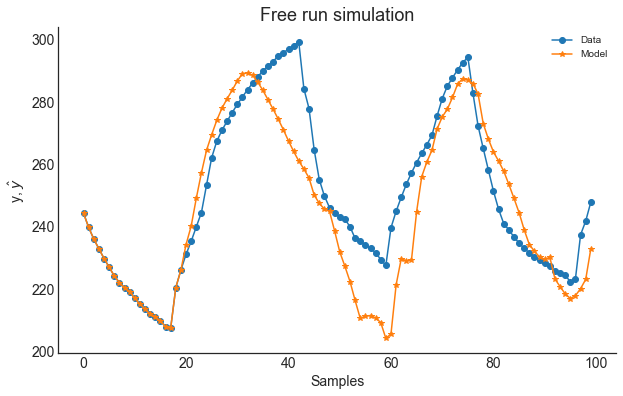

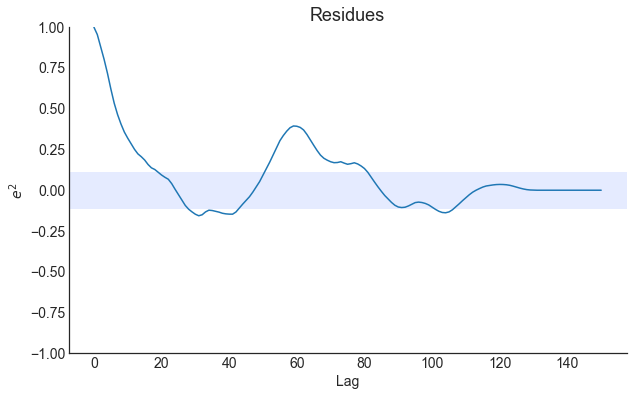

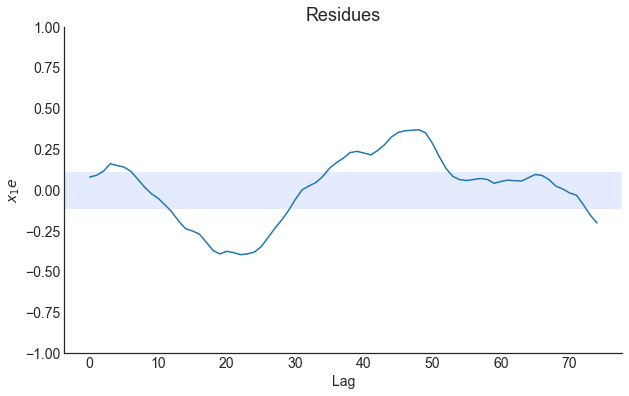

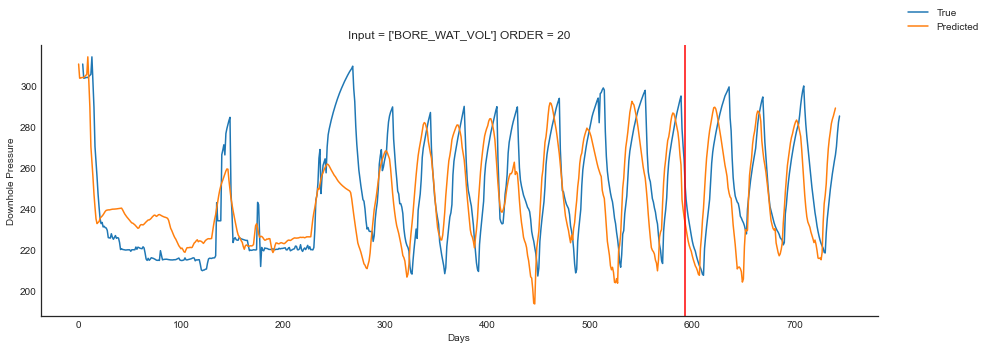

#####################################################################
FEATURES SELECTED =  ['AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.5330001744484459
R2:  0.92641
#####################################################################
 Order Selected:     15
RMSE:  0.553862160797716
R2:  0.9074
#####################################################################
 Order Selected:     20
RMSE:  0.6847257443904214
R2:  0.73689


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,3.474012,0.024196,False
3,4,0.733258,0.736186,False
4,5,0.305368,0.926282,False
5,10,0.284089,0.926406,True
6,15,0.306763,0.907399,False
7,20,0.468849,0.736888,False


0.9264062119280017 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E2205A7310> 10
         Regressors   Parameters             ERR
0            y(k-1)   1.1837E+00  9.99448945E-01
1      y(k-9)y(k-3)   1.8132E-07  1.18122702E-04
2     x1(k-1)y(k-2)   1.8155E-03  2.61223399E-05
3      y(k-2)y(k-1)  -6.4768E-04  4.78870123E-05
4         x1(k-2)^2   1.9229E-03  9.29820879E-06
5           x1(k-3)  -1.1813E-01  1.20605251E-05
6  x1(k-20)x1(k-18)  -7.1323E-04  4.89262560E-06
7     y(k-19)y(k-6)  -2.5525E-03  1.83697344E-06
8   x1(k-10)x1(k-5)   2.2329E-03  2.96075254E-06
9    x1(k-1)y(k-10)  -2.0845E-03  4.45593441E-06


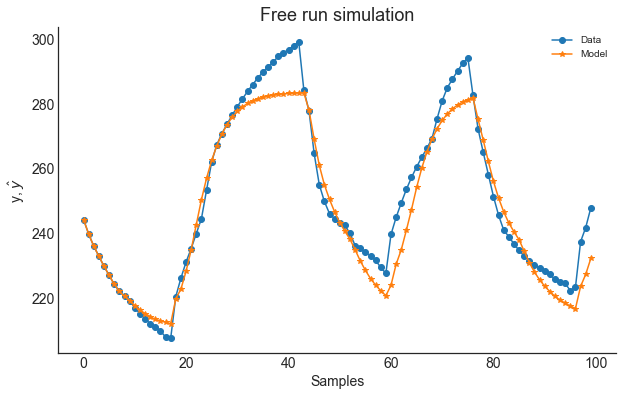

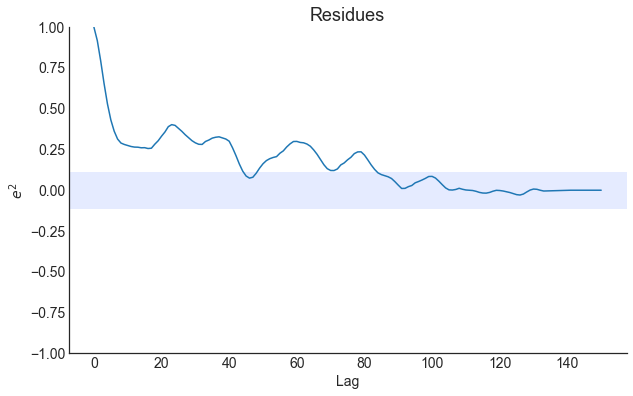

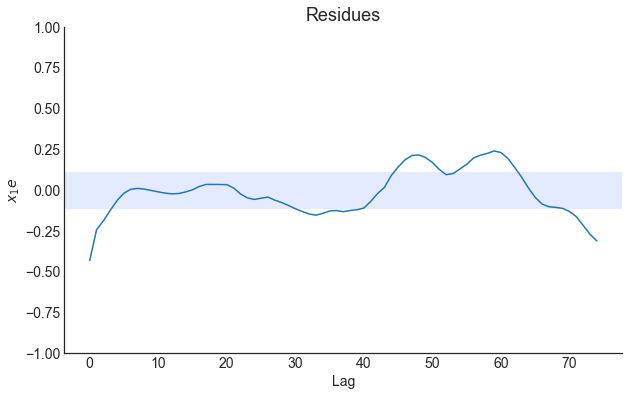

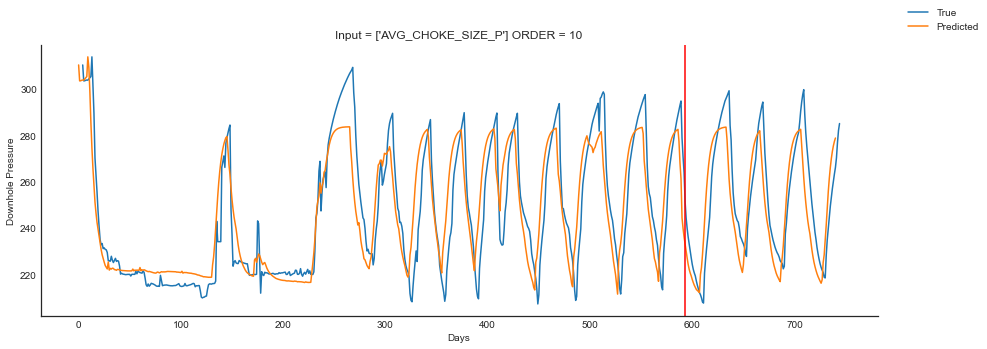

#####################################################################
FEATURES SELECTED =  ['ON_STREAM_HRS']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3


C:\Users\danie\anaconda3\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6 
  self.info_values = self.information_criterion(reg_matrix, y)


RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5470831651413882
R2:  0.91902
#####################################################################
 Order Selected:     15
RMSE:  0.5516264178505365
R2:  0.91094
#####################################################################
 Order Selected:     20
RMSE:  0.5717723974312638
R2:  0.89274


,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,False
1,2,1.237651,-2.230956,False
2,3,3.474012,0.024196,False
3,4,0.618929,0.790729,False
4,5,0.306499,0.924779,True
5,10,0.299300,0.919024,False
6,15,0.304292,0.910943,False
7,20,0.326924,0.892742,False


0.9247785474800367 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E22071DC10> 5
       Regressors   Parameters             ERR
0          y(k-1)   9.6989E-01  9.99454016E-01
1    y(k-9)y(k-3)   1.9187E-01  1.05713822E-04
2  x1(k-9)x1(k-1)   7.3094E-05  3.01848790E-05
3  x1(k-9)x1(k-2)  -1.6505E-03  1.66929616E-05
4  y(k-20)y(k-10)  -6.3744E-04  4.95231223E-05


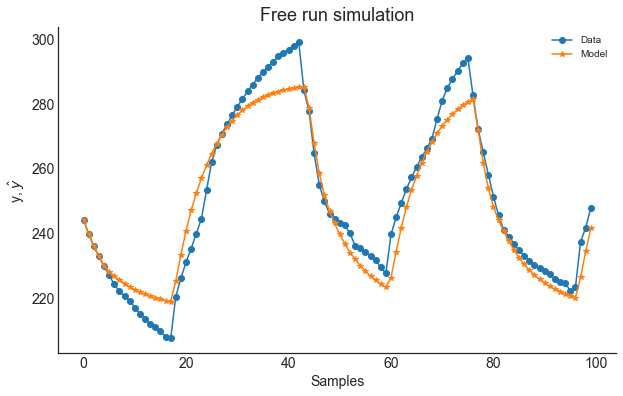

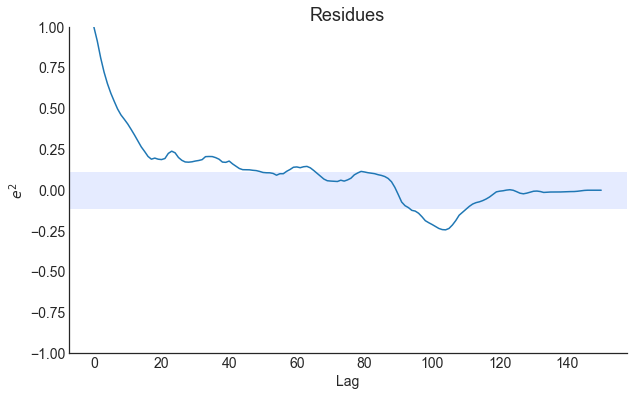

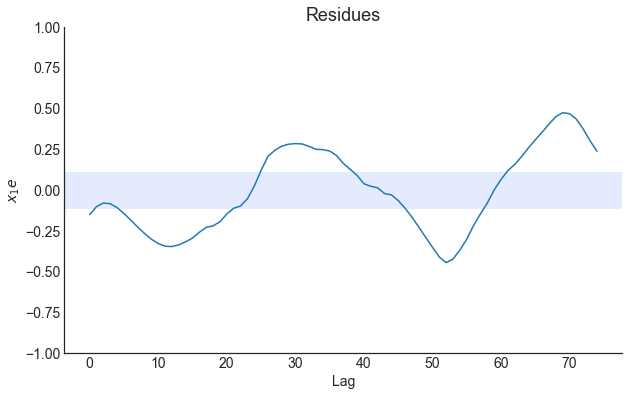

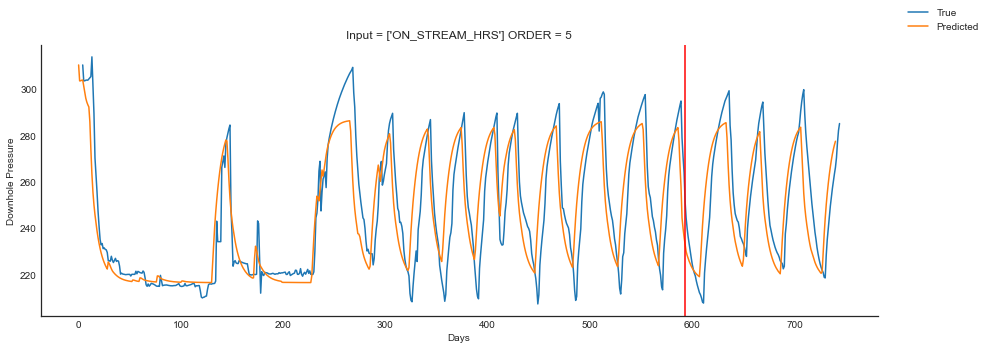

In [11]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [1,2,3,4,5,10,15,20]

for feature in np.arange(2,8):
    
    r2_best = 0
    history = []
    results_ = pd.DataFrame()

    X_inputs = inputs_selection([feature])
    #best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']

    train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
    train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
    print('#####################################################################')
    print('FEATURES SELECTED = ', inputs_selection([feature]))
    print('#####################################################################')
    
    for order in tqdm(n_order):
    
        print('#####################################################################')
        print(' Order Selected:    ',order)                


        basis_function = Polynomial(degree=2)

        lag = list(range(1,order+1))
        model = FROLS(
            order_selection=True,
            n_terms=order,
            extended_least_squares=False,
            ylag=order, xlag=order,
            info_criteria='bic',
            estimator='least_squares',
            basis_function=basis_function
        )

        model.fit(X = train_X, y = train_y)

        yhat = model.predict(X=test_X, y=test_y)
        
        try:
            r2 = r2_score(test_y, yhat)
            rrse = root_relative_squared_error(test_y, yhat)
        except:
            print('MODEL FAILED')
            r2 = 0
            rrse = 0
            pass
        
        print('RMSE: ',rrse)
        print('R2: ',round(r2,5))


        history.append([order,rrse,r2])

        if r2 > r2_best:      
            r2_best = r2
            best_model = model
            best_order = order

    History = pd.DataFrame(history, columns = ['Order','RMSE','R2'])
    History['Best'] = (History['R2'] == r2_best)

    display(History)

    print(r2_best,best_model,best_order)

    yhat = best_model.predict(X=test_X, y=test_y)
    
    
    results_ = pd.DataFrame(
        results(
            model.final_model, best_model.theta, best_model.err,
            best_model.n_terms, err_precision=8, dtype='sci'),
        columns=['Regressors', 'Parameters', 'ERR'])
    print(results_)
    
    plot_results(y=test_y, yhat = yhat)

    ee = compute_residues_autocorrelation(test_y, yhat)
    plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
    x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
    plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

    results_sysid = []
    results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

    fig,ax1 = plt.subplots(figsize=(15, 5))
    ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
    ax1.plot(results_sysid, label = 'Predicted')
    ax1.axvline(x=train_index,color = 'r')
    ax1.set_title(f'Input = {inputs_selection([feature])} ORDER = {best_order}',)
    ax1.set_ylabel('Downhole Pressure')
    ax1.set_xlabel('Days')

    fig.legend( loc = 'upper right')
    plt.show()


(2, 3)
#####################################################################
FEATURES SELECTED =  ['AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL']
#####################################################################


  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.5783247284276403
R2:  0.92189
#####################################################################
 Order Selected:     15
RMSE:  0.4954911032912065
R2:  0.95214
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.9623036876860598
R2:  0.64986
#####################################################################
 Order Selected:     5
RMSE:  0.6297262405438924
R2:  0.88832
#####################################################################
 Order Selected:     10
RMSE:  0.5577586607211279
R2:  0.93437
#####################################################################
 Order Selected:     15
RMSE:  0.507194292673911
R2:  0.94929
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.9623036876860598
R2:  0.64986
#####################################################################
 Order Selected:     5
RMSE:  0.6297262405438924
R2:  0.88832
#####################################################################
 Order Selected:     10
RMSE:  0.6681915924521147
R2:  0.81808
#####################################################################
 Order Selected:     15
RMSE:  0.6213882499959761
R2:  0.83623
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.5654920121993195
R2:  0.9163
#####################################################################
 Order Selected:     15
RMSE:  0.5462421877174719
R2:  0.92411
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5589353337045591
R2:  0.91303
#####################################################################
 Order Selected:     15
RMSE:  0.5807044004913301
R2:  0.89453
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.6666965926328711
R2:  0.88134
#####################################################################
 Order Selected:     15
RMSE:  0.6444294711593039
R2:  0.89048
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.6651990467018175
R2:  0.8766
#####################################################################
 Order Selected:     15
RMSE:  0.6528030581626402
R2:  0.87851
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5011781769352444
R2:  0.94385
#####################################################################
 Order Selected:     15
RMSE:  0.5243528834556386
R2:  0.93347
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5470831651413882
R2:  0.91902
#####################################################################
 Order Selected:     15
RMSE:  0.5516264178505365
R2:  0.91094
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.0077406453814355
R2:  -0.00288
#####################################################################
 Order Selected:     5
RMSE:  0.9292486373428176
R2:  0.06147
#####################################################################
 Order Selected:     10
RMSE:  0.8160619713638408
R2:  0.74581
#####################################################################
 Order Selected:     15
RMSE:  0.6881399653711917
R2:  0.81494
#####################################################################
 Ord

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.5330001744484459
R2:  0.92641
#####################################################################
 Order Selected:     15
RMSE:  0.49864538626835
R2:  0.94548
#####################################################################
 Order S

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5470831651413882
R2:  0.91902
#####################################################################
 Order Selected:     15
RMSE:  0.5516264178505365
R2:  0.91094
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.5330001744484459
R2:  0.92641
#####################################################################
 Order Selected:     15
RMSE:  0.5298603458002651
R2:  0.92858
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5995031714862852
R2:  0.86479
#####################################################################
 Order Selected:     15
RMSE:  0.6193401745791981
R2:  0.82956
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.5550306089678043
R2:  0.91203
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.5783247284276403
R2:  0.92189
#####################################################################
 Order Selected:     15
RMSE:  0.5174653913454402
R2:  0.94445
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.6545609883593663
R2:  0.8276
#####################################################################
 Order Selected:     15
RMSE:  0.5545070213745311
R2:  0.91882
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5442727289304528
R2:  0.93151
#####################################################################
 Order Selected:     15
RMSE:  0.47695334624860175
R2:  0.95507
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5589353337045591
R2:  0.91303
#####################################################################
 Order Selected:     15
RMSE:  0.5807044004913301
R2:  0.89453
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.9623036876860598
R2:  0.64986
#####################################################################
 Order Selected:     5
RMSE:  0.6297262405438924
R2:  0.88832
#####################################################################
 Order Selected:     10
RMSE:  0.7102768527287824
R2:  0.84372
#####################################################################
 Order Selected:     15
RMSE:  0.5291879104105998
R2:  0.93533
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.5654920121993195
R2:  0.9163
#####################################################################
 Order Selected:     15
RMSE:  0.5462421877174719
R2:  0.92411
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5589353337045591
R2:  0.91303
#####################################################################
 Order Selected:     15
RMSE:  0.5509904111384639
R2:  0.91025
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.6228269085042346
R2:  0.8557
#####################################################################
 Order Selected:     15
RMSE:  0.6473823509762866
R2:  0.82717
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.6228506176319338
R2:  0.84197
#####################################################################
 Order Selected:     15
RMSE:  0.6271833888213106
R2:  0.83496
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.565832329477174
R2:  0.90369
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.6526990876250685
R2:  0.88688
#####################################################################
 Order Selected:     15
RMSE:  0.6528030581626402
R2:  0.87851
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5011781769352444
R2:  0.94385
#####################################################################
 Order Selected:     15
RMSE:  0.5243528834556386
R2:  0.93347
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5470831651413882
R2:  0.91902
#####################################################################
 Order Selected:     15
RMSE:  0.5516264178505365
R2:  0.91094
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5011781769352444
R2:  0.94385
#####################################################################
 Order Selected:     15
RMSE:  0.5355180913039213
R2:  0.93538
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5995031714862852
R2:  0.86479
#####################################################################
 Order Selected:     15
RMSE:  0.6193401745791981
R2:  0.82956
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.5550306089678043
R2:  0.91203
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.5372104604398572
R2:  0.92992
#####################################################################
 Order Selected:     15
RMSE:  0.5123291977606091
R2:  0.94009
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5995031714862852
R2:  0.86479
#####################################################################
 Order Selected:     15
RMSE:  0.6193401745791981
R2:  0.82956
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.5550306089678043
R2:  0.91203
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.6300667531501633
R2:  0.83686
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  1.2696195773812604
R2:  0.51196
#####################################################################
 Order Selected:     5
RMSE:  1.3563261686623191
R2:  0.49771
#####################################################################
 Order Selected:     10
RMSE:  0.6545609883593663
R2:  0.8276
#####################################################################
 Order Selected:     15
RMSE:  0.572198381601748
R2:  0.90188
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5442727289304528
R2:  0.93151
#####################################################################
 Order Selected:     15
RMSE:  0.47695334624860175
R2:  0.95507
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5589353337045591
R2:  0.91303
#####################################################################
 Order Selected:     15
RMSE:  0.5422515843296281
R2:  0.9173
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5442727289304528
R2:  0.93151
#####################################################################
 Order Selected:     15
RMSE:  0.5851820257854462
R2:  0.88801
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5644582500212579
R2:  0.91007
#####################################################################
 Order Selected:     15
RMSE:  0.5358332490523557
R2:  0.9277
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.5213647710190912
R2:  0.93836
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  0.5526012097126677
R2:  0.92628
#####################################################################
 Order Selected:     10
RMSE:  0.5643816442295689
R2:  0.91435
#####################################################################
 Order Selected:     15
RMSE:  0.5720875115431137
R2:  0.89888
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.568180515016429
R2:  0.90612
#####################################################################
 Order Selected:     15
RMSE:  0.5650474329822196
R2:  0.90351
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.565832329477174
R2:  0.90369
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.565832329477174
R2:  0.90369
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5011781769352444
R2:  0.94385
#####################################################################
 Order Selected:     15
RMSE:  0.5229195855641171
R2:  0.93994
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5995031714862852
R2:  0.86479
#####################################################################
 Order Selected:     15
RMSE:  0.6193401745791981
R2:  0.82956
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.5550306089678043
R2:  0.91203
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.6300667531501633
R2:  0.83686
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.6300667531501633
R2:  0.83686
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.856304846034274
R2:  0.73619
#####################################################################
 Order Selected:     5
RMSE:  1.440049855426301
R2:  0.46847
#####################################################################
 Order Selected:     10
RMSE:  0.5442727289304528
R2:  0.93151
#####################################################################
 Order Selected:     15
RMSE:  0.5786452484316162
R2:  0.89191
#####################################################################
 Order 

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.568180515016429
R2:  0.90612
#####################################################################
 Order Selected:     15
RMSE:  0.5506053632422037
R2:  0.91773
#####################################################################
 Order

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.5213647710190912
R2:  0.93836
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.5403491805004134
R2:  0.92531
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.5479365673255348
R2:  0.92125
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5425771849101192
R2:  0.92337
#####################################################################
 Order Selected:     15
RMSE:  0.6300667531501633
R2:  0.83686
#####################################################################
 Orde

  0%|          | 0/8 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     1
RMSE:  1.2363414785231521
R2:  -0.889
#####################################################################
 Order Selected:     2
RMSE:  1.1124977037954071
R2:  -2.23096
#####################################################################
 Order Selected:     3
RMSE:  1.8638702721369569
R2:  0.0242
#####################################################################
 Order Selected:     4
RMSE:  0.7867204838990566
R2:  0.79073
#####################################################################
 Order Selected:     5
RMSE:  0.5536231680827026
R2:  0.92478
#####################################################################
 Order Selected:     10
RMSE:  0.5459366807630849
R2:  0.91668
#####################################################################
 Order Selected:     15
RMSE:  0.5438705783684504
R2:  0.92221
#####################################################################
 Orde

,Combination Number,Order,RMSE,R2,Best
0,1,1.528540,-0.888996,NaN,False
1,2,1.237651,-2.230956,NaN,False
2,3,3.474012,0.024196,NaN,False
3,4,0.618929,0.790729,NaN,False
4,5,0.306499,0.924779,NaN,False
...,...,...,...,...,...
459,"(2, 3, 4, 5, 6, 7)",4.000000,0.618929,0.790729,False
460,"(2, 3, 4, 5, 6, 7)",5.000000,0.306499,0.924779,False
461,"(2, 3, 4, 5, 6, 7)",10.000000,0.298047,0.916680,False
462,"(2, 3, 4, 5, 6, 7)",15.000000,0.295795,0.922210,False


0.9550691881434058 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001E2201FD460> 15
       Regressors   Parameters             ERR
0          y(k-1)   9.6989E-01  9.99454016E-01
1    y(k-9)y(k-3)   1.9187E-01  1.05713822E-04
2  x6(k-9)x6(k-1)   7.3094E-05  3.01848790E-05
3  x6(k-9)x6(k-2)  -1.6505E-03  1.66929616E-05
4   x1(k-6)y(k-1)  -6.3744E-04  4.95231223E-05


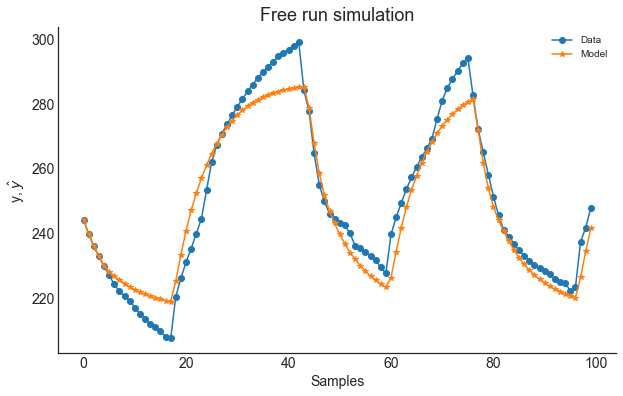

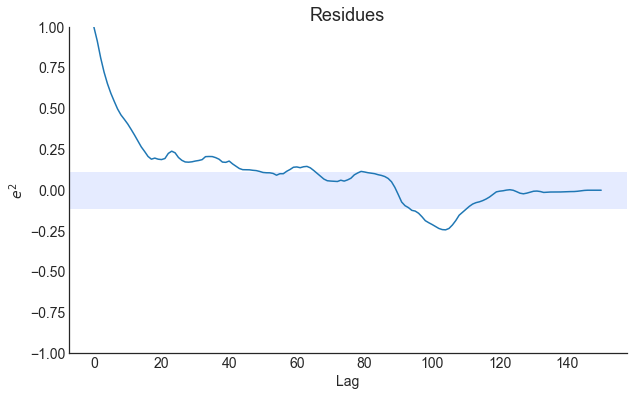

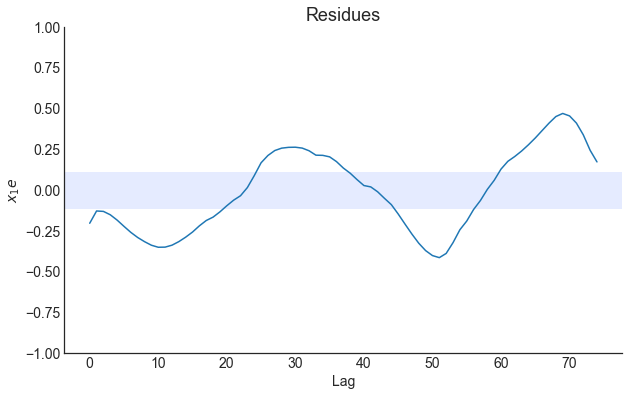

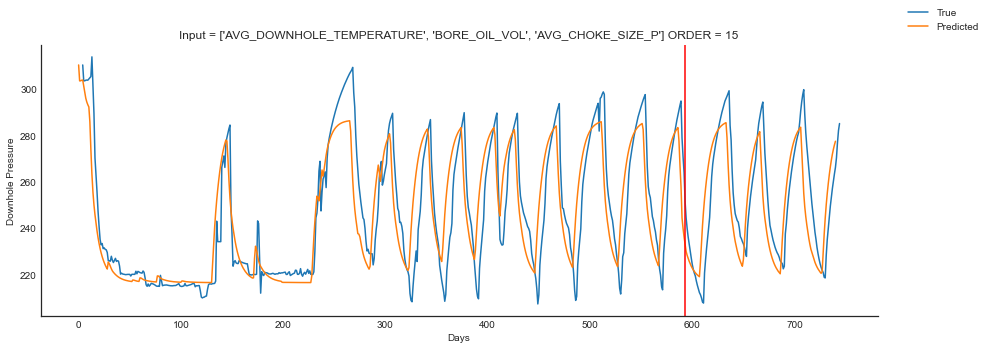

In [12]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [1,2,3,4,5,10,15,20]

combinations_= []
feature = np.arange(2,8)
for L in range(2, len(feature)+1):
    for subset in itertools.combinations(feature, L):
        #X_inputs = inputs_selection([subset])
        combinations_.append(subset)

r2_best = 0

for feature in combinations_:
    print(feature)

    X_inputs = inputs_selection(feature)
    #best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']
    
    feature_r2_best = 0
    
    results_ = pd.DataFrame()
    
    train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
    train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
    
    print('#####################################################################')
    print('FEATURES SELECTED = ', inputs_selection(feature))
    print('#####################################################################')
    
    for order in tqdm(n_order):
        
        print('#####################################################################')
        print(' Order Selected:    ',order)                


        basis_function = Polynomial(degree=2)

        lag = list(range(1,order+1))
        model = FROLS(
            order_selection=True,
            n_terms=order,
            extended_least_squares=False,
            ylag=order, xlag=[lag]*len(feature),
            info_criteria='bic',
            estimator='least_squares',
            basis_function=basis_function
        )

        model.fit(X = train_X, y = train_y)

        yhat = model.predict(X=test_X, y=test_y)
        
        try:
            r2 = r2_score(test_y, yhat)
            rrse = root_relative_squared_error(test_y, yhat)
        except:
            print('MODEL FAILED')
            r2 = 0
            rrse = 0
            pass
        
        print('RMSE: ',rrse)
        print('R2: ',round(r2,5))


        if r2 > feature_r2_best:      
            feature_r2_best = r2
            feature_rrse_best = rrse
            best_model = model
            feature_best_order = order

        history.append([feature,order,rrse,r2])
            
        if r2 > r2_best:      
            r2_best = feature_r2_best
            rrse_best = feature_rrse_best
            best_model = model
            best_order = order
            best_inputs = inputs_selection(feature)
            
    
History = pd.DataFrame(history, columns = ['Combination Number','Order','RMSE','R2'])
History['Best'] = (History['R2'] == r2_best)

display(History)

print(r2_best,best_model,best_order)

yhat = best_model.predict(X=test_X, y=test_y)


results_ = pd.DataFrame(
    results(
        model.final_model, best_model.theta, best_model.err,
        best_model.n_terms, err_precision=8, dtype='sci'),
    columns=['Regressors', 'Parameters', 'ERR'])
print(results_)

plot_results(y=test_y, yhat = yhat)

ee = compute_residues_autocorrelation(test_y, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

results_sysid = []
results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

fig,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
ax1.plot(results_sysid, label = 'Predicted')
ax1.axvline(x=train_index,color = 'r')
ax1.set_title(f'Input = {best_inputs} ORDER = {best_order}',)
ax1.set_ylabel('Downhole Pressure')
ax1.set_xlabel('Days')

fig.legend( loc = 'upper right')
plt.show()

History.to_excel("NARX_Output.xlsx")  